In [2]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib import style
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from pandas.plotting import autocorrelation_plot
style.use('dark_background')
import datetime
import statsmodels.api as sm
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
%matplotlib inline

In [3]:
df = pd.read_csv('acceleration.csv',header=1, parse_dates=['Time'], index_col='Time')
df.columns = ['acceleration']
df['acceleration'] = df['acceleration'].str.replace(' m/s²', '').astype(float)
df.head(20)

acceleration
Time                             
2021-12-09 09:42:35          15.0
2021-12-09 09:43:35          15.5
2021-12-09 09:44:35          15.1
2021-12-09 09:45:35          14.7
2021-12-09 09:46:36          13.0
2021-12-09 09:47:35          15.9
2021-12-09 09:48:35          14.8
2021-12-09 09:49:35          16.8
2021-12-09 09:50:35          16.9
2021-12-09 09:51:36          14.2
2021-12-09 09:52:35          15.5
2021-12-09 09:53:35          14.6
2021-12-09 09:54:35          14.5
2021-12-09 09:55:35          14.4
2021-12-09 09:56:36          14.0
2021-12-09 09:57:35          14.2
2021-12-09 09:58:35          12.4
2021-12-09 09:59:35          15.2
2021-12-09 10:00:35          15.7
2021-12-09 10:01:35          13.9

In [6]:
df.loc[df['acceleration']<0.2,:]

acceleration
Time                             
2021-12-09 21:50:03           0.1
2021-12-09 21:51:03           0.1
2021-12-09 21:56:03           0.1
2021-12-09 21:59:03           0.1
2021-12-09 22:02:04           0.1
...                           ...
2022-06-09 05:39:31           0.1
2022-06-09 05:43:31           0.1
2022-06-09 05:45:32           0.1
2022-06-09 05:50:32           0.1
2022-06-09 05:53:31           0.1

[73724 rows x 1 columns]

In [426]:
df.fillna(method='backfill',inplace=True)


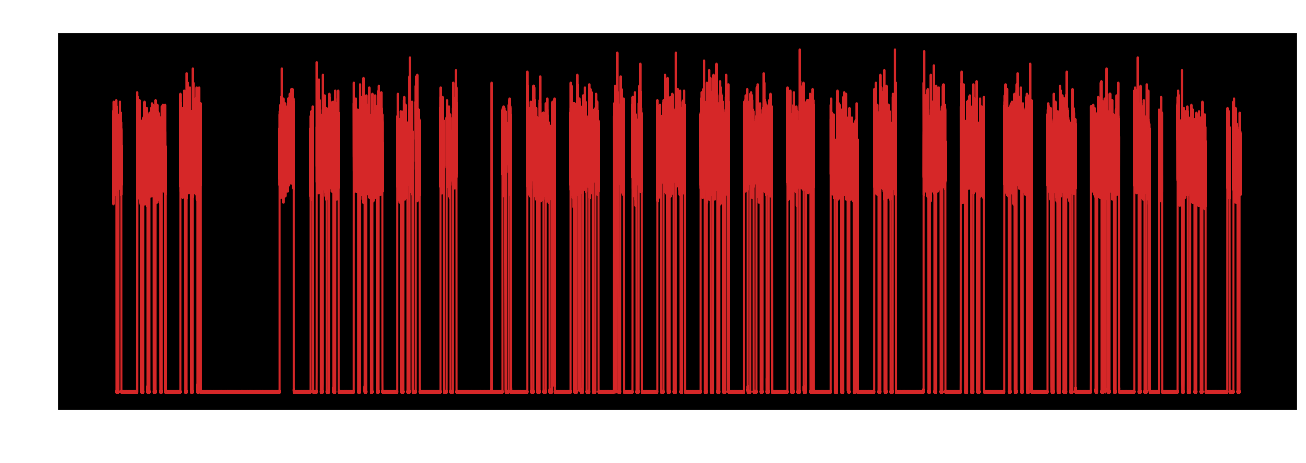

In [427]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df.index, df['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

In [428]:
#Histogram with 3 standard deviations
plt.figure(figsize=(10,5), dpi=100)
# plt.hist(df['acceleration'], bins = 20
sns.histplot(df['acceleration'], bins = 20)
# plt.axvline(x=df['acceleration'].mean()+3*df['acceleration'].std(), color='red',ls= '--')
# plt.axvline(x=df['acceleration'].mean()-3*df['acceleration'].std(), color='red',ls= '--')
plt.title('Histogram of all values')
plt.show()


In [429]:
df['acceleration'].describe()

count    262154.000000
mean          5.732547
std           7.151464
min           0.100000
25%           0.100000
50%           0.200000
75%          14.300000
max          21.800000
Name: acceleration, dtype: float64

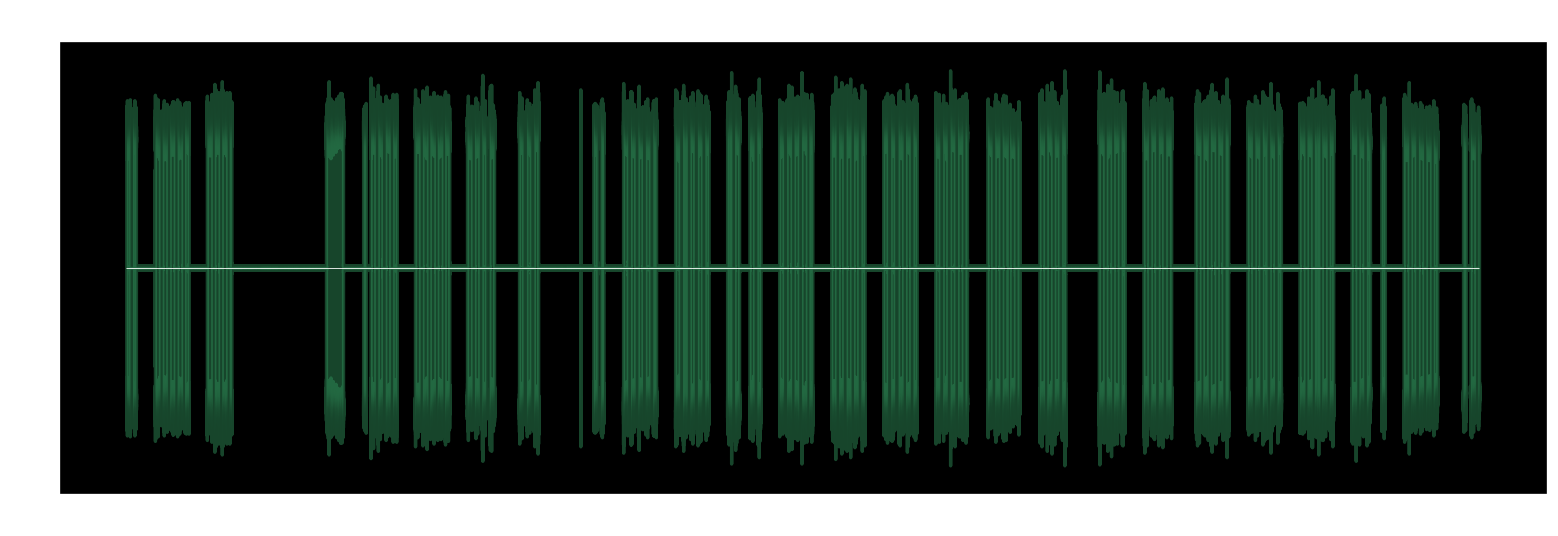

In [430]:
# Mirror axis
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(df.index, y1=df['acceleration'], y2=-df['acceleration'], alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-25, 25)
plt.title('Acceleration two side view', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

In [431]:
df_hour = df.resample('H').median()
df_hour['weekday'] = [d.strftime('%a') for d in df_hour.index]
df_hour['hour'] = [d.strftime('%H') for d in df_hour.index]
df_hour['yearweek'] = [d.strftime('%W') for d in df_hour.index]
df_hour['month'] = [d.strftime('%b') for d in df_hour.index]
df_hour['yearday'] = [d.strftime('%j') for d in df_hour.index]
df_hour['year'] = [d.strftime('%Y') for d in df_hour.index]
df_hour['hour']=df_hour['hour'].astype(int)

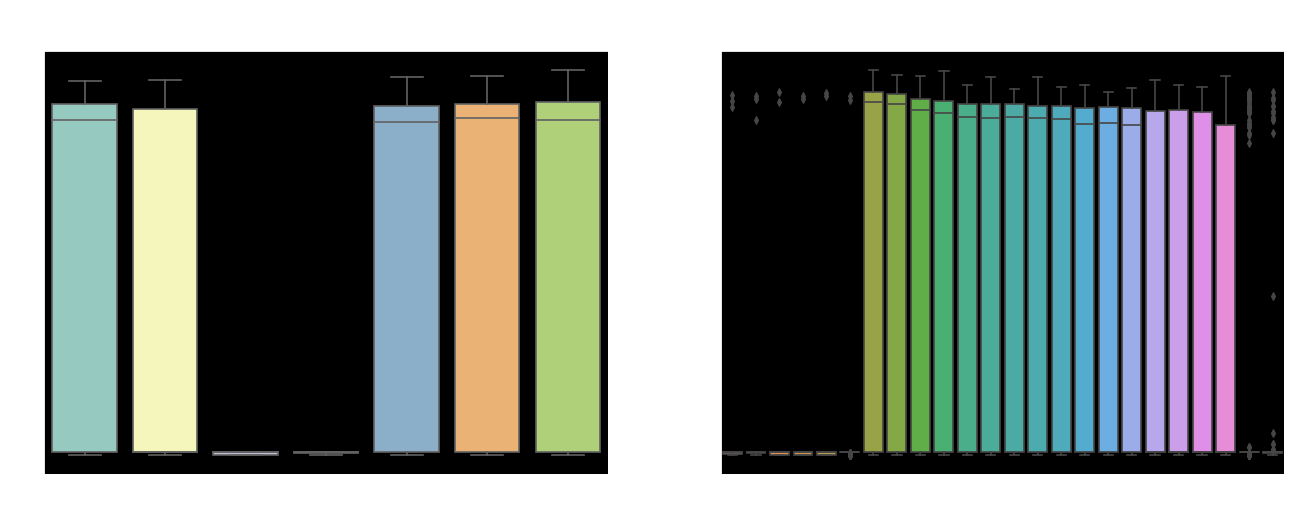

In [432]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='weekday', y='acceleration', data=df_hour, ax=axes[0])
sns.boxplot(x='hour', y='acceleration', data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :])

# Set Title
axes[0].set_title('Week-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

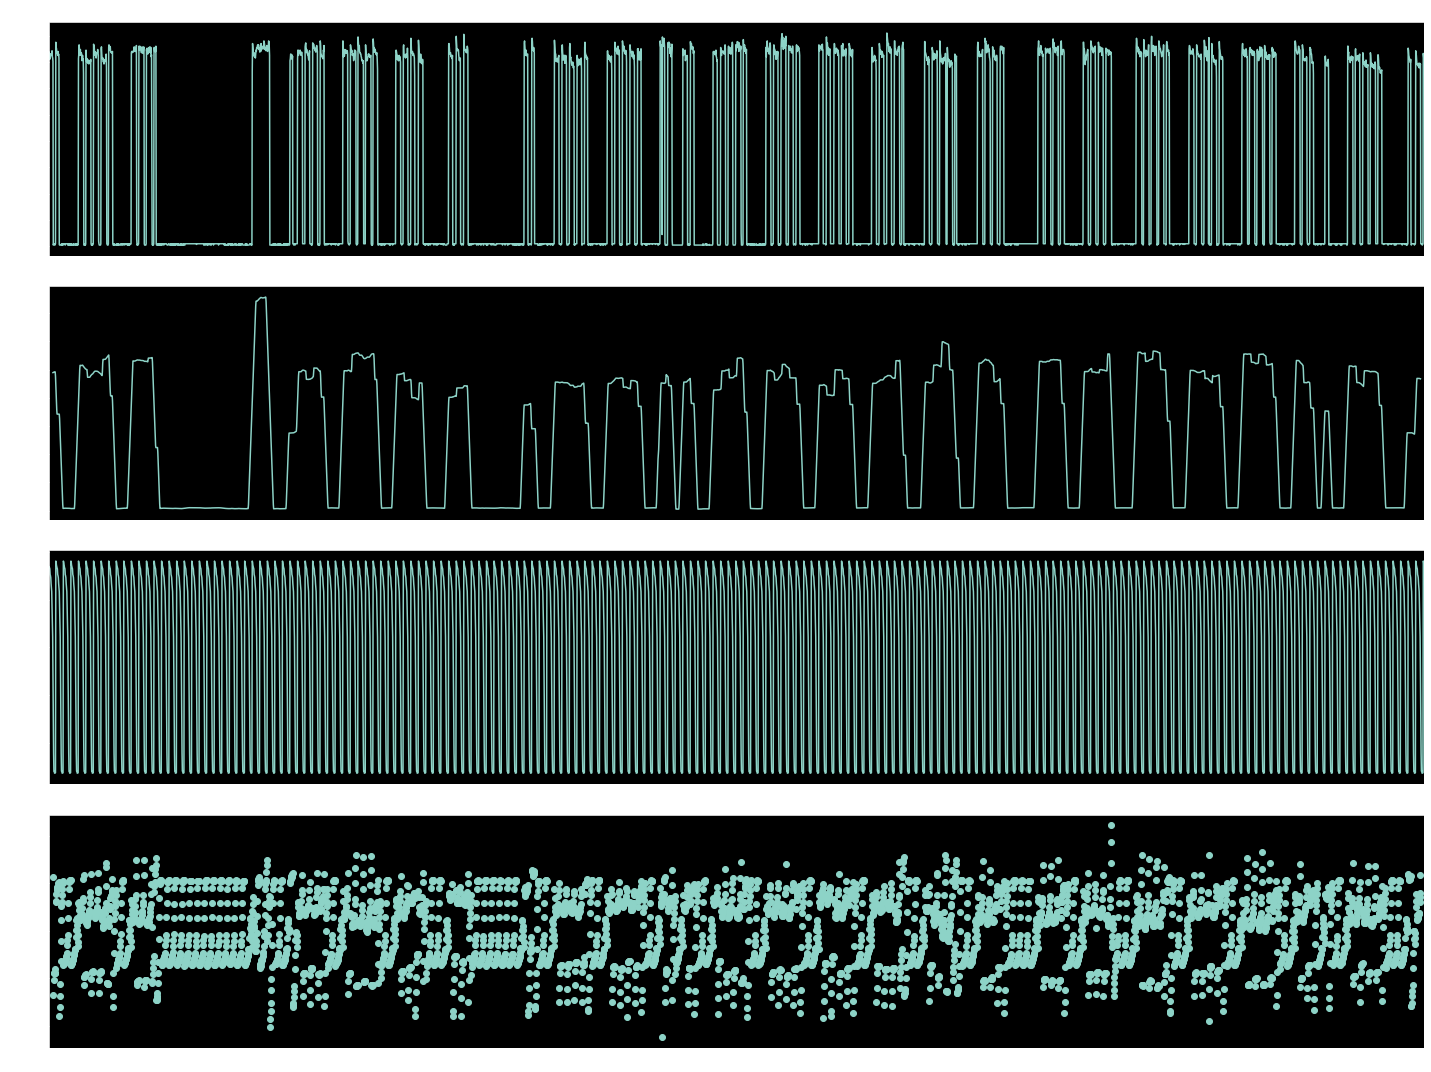

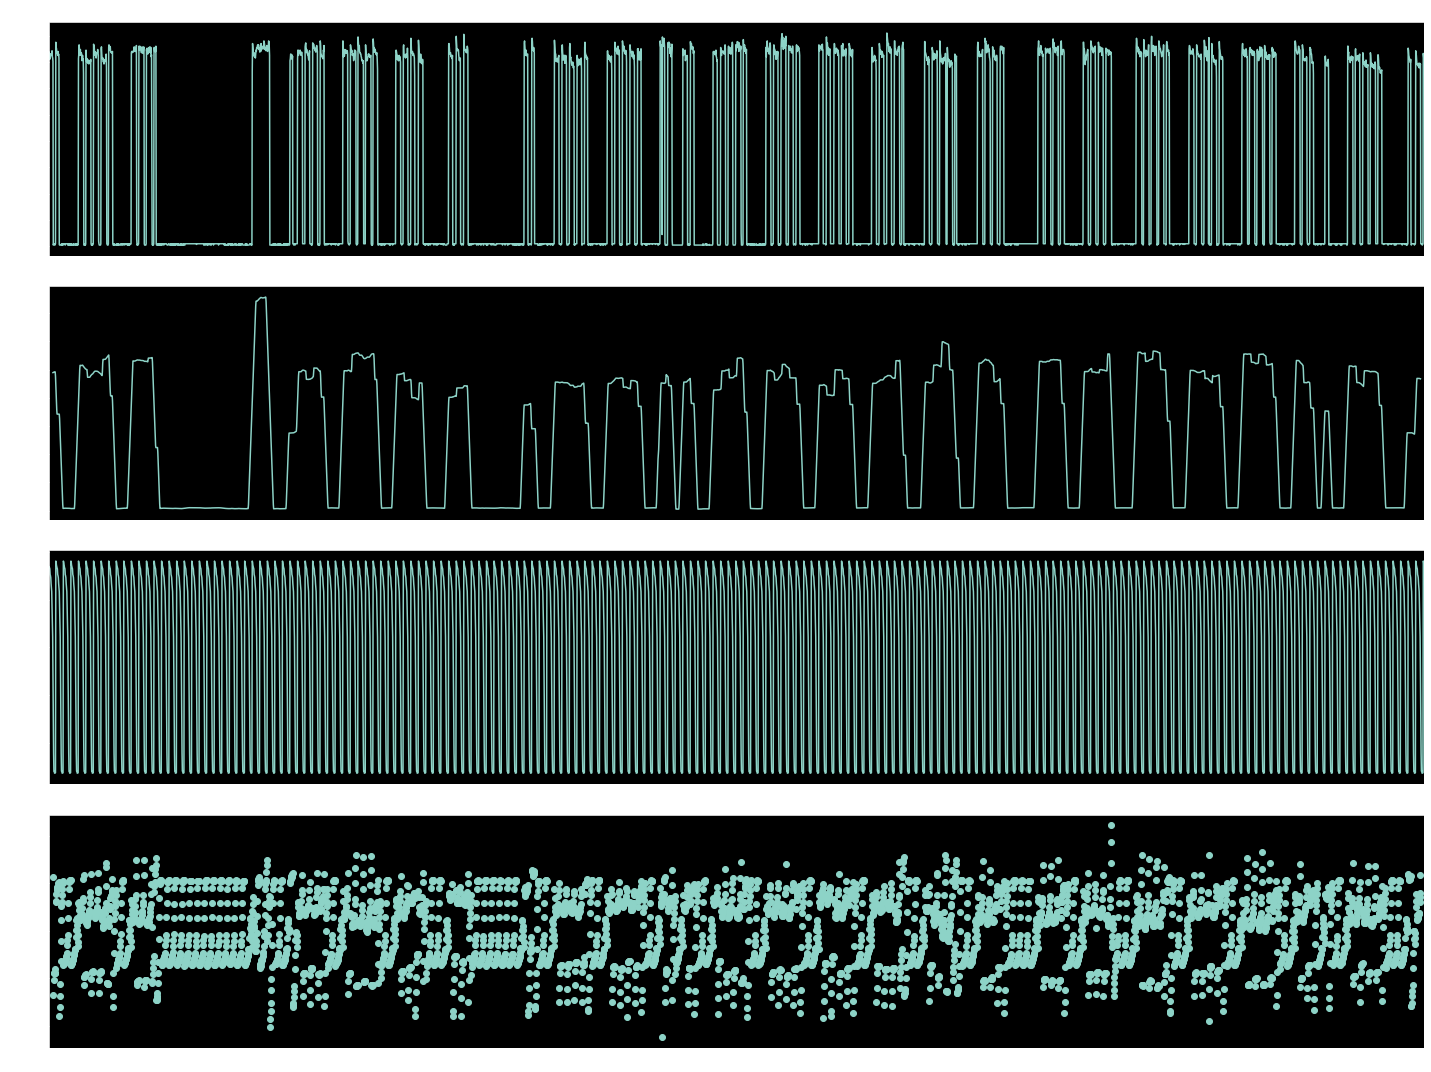

In [433]:

df_hour['acceleration']=df_hour['acceleration'].fillna(method='backfill')

decomposition = sm.tsa.seasonal_decompose(df_hour['acceleration'])

rcParams["figure.figsize"] = 20, 15
decomposition.plot()

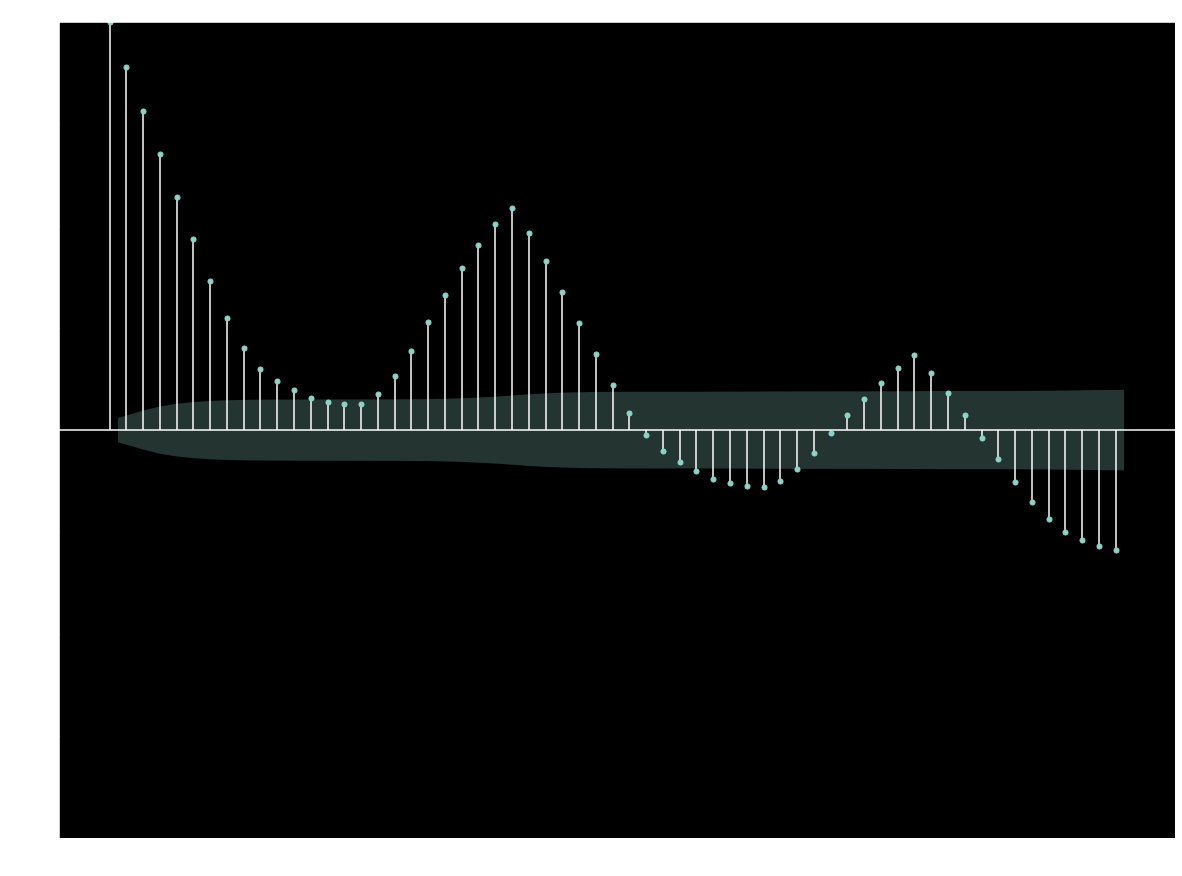

In [434]:
from statsmodels.graphics import tsaplots


# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(df_hour['acceleration'], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


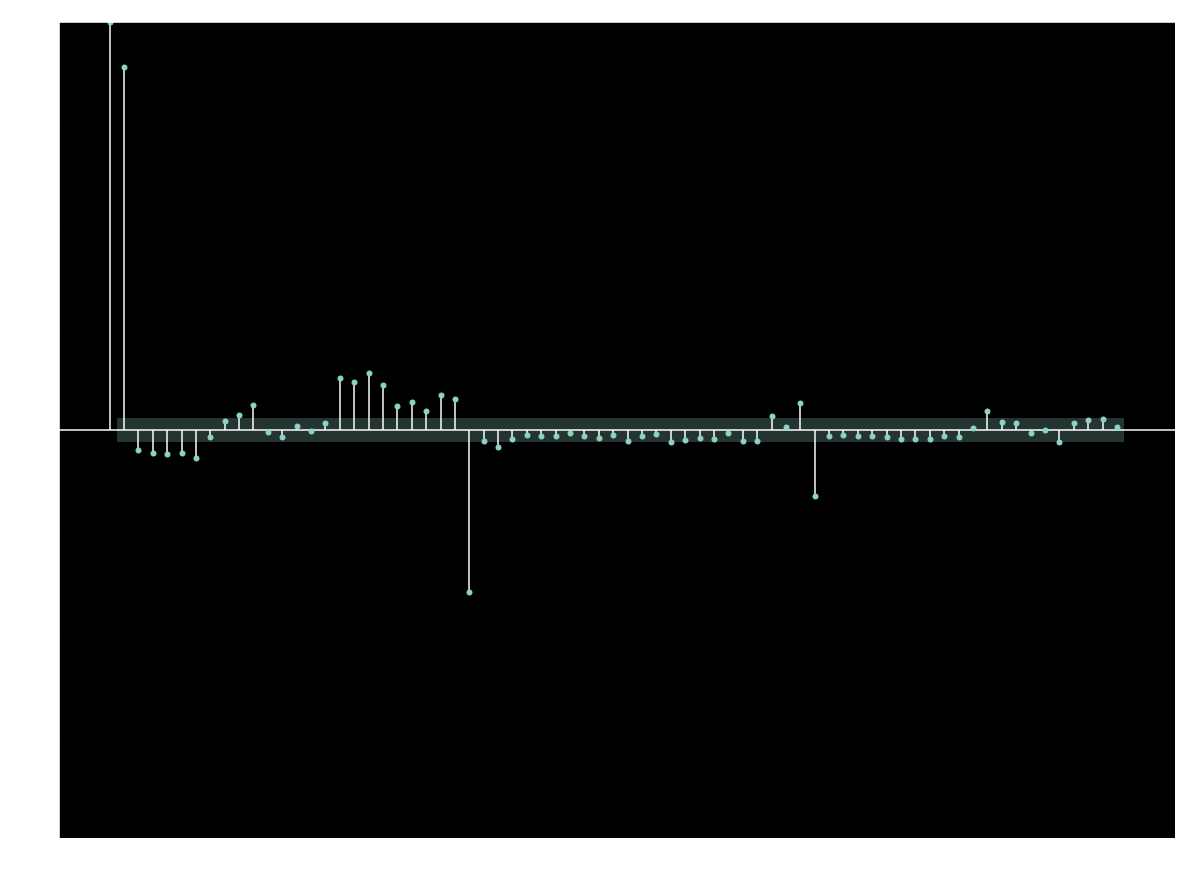

In [435]:
fig = tsaplots.plot_pacf(df_hour['acceleration'], lags=70)

plt.title("Partial Autocorrelation of Benzene")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

In [436]:
#Explore the whole series without lower values
df_hour=df_hour[df_hour['acceleration']>12]
df_hour

acceleration weekday  hour yearweek month yearday  year
Time                                                                        
2021-12-09 09:00:00         14.75     Thu     9       49   Dec     343  2021
2021-12-09 10:00:00         14.20     Thu    10       49   Dec     343  2021
2021-12-09 11:00:00         14.45     Thu    11       49   Dec     343  2021
2021-12-09 12:00:00         14.25     Thu    12       49   Dec     343  2021
2021-12-09 13:00:00         14.45     Thu    13       49   Dec     343  2021
...                           ...     ...   ...      ...   ...     ...   ...
2022-06-08 21:00:00         13.85     Wed    21       23   Jun     159  2022
2022-06-09 06:00:00         14.65     Thu     6       23   Jun     160  2022
2022-06-09 07:00:00         14.40     Thu     7       23   Jun     160  2022
2022-06-09 08:00:00         14.20     Thu     8       23   Jun     160  2022
2022-06-09 09:00:00         14.10     Thu     9       23   Jun     160  2022

[1638 rows x 7 columns]

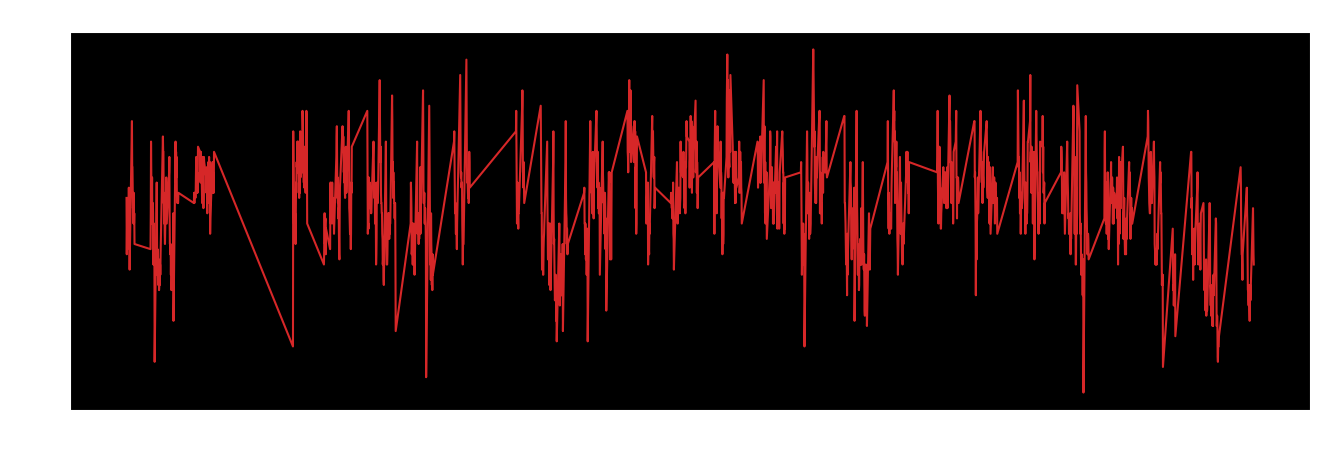

In [437]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_hour.index, df_hour['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

In [438]:
#Box plot of daily based on week of the year

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='yearweek', y='acceleration', data=df_hour, ax=axes[0])
sns.boxplot(x='hour', y='acceleration', data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :])

# Set Title
axes[0].set_title('Week-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [439]:
plt.figure(figsize=(16,5),dpi=100)
ax = sns.violinplot(x='hour', y='acceleration',
                    data=df_hour.loc[~df_hour.yearweek.isin([1, 52]),:], palette="Set2", split=True,
                    scale="count")

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

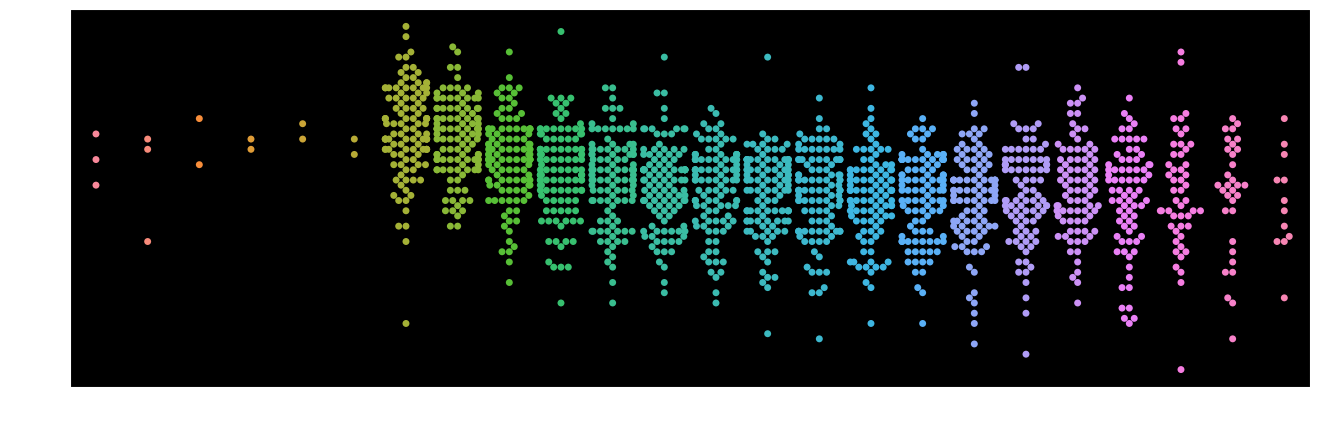

In [440]:
plt.figure(figsize=(16,5), dpi=100)
ax = sns.swarmplot(x='hour', y='acceleration',
                    data=df_hour.loc[~df_hour.yearweek.isin([1, 52]),:])

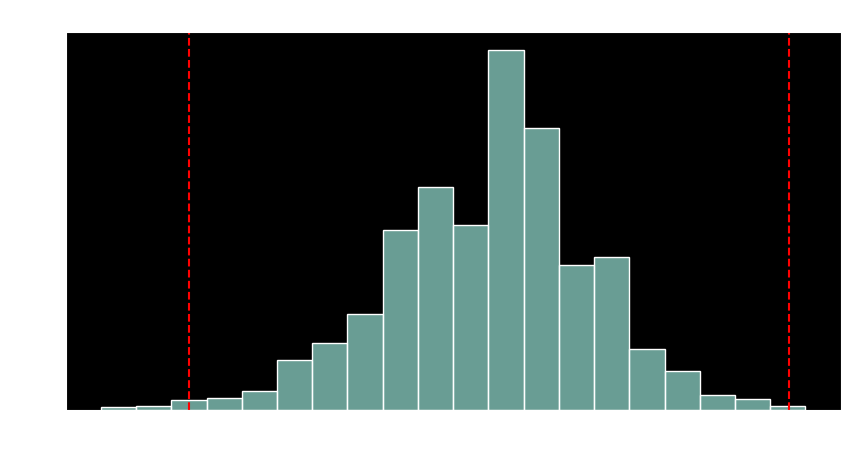

In [441]:
#Histogram with 3 standard deviations
plt.figure(figsize=(10,5), dpi=100)
# plt.hist(df_hour['acceleration'], bins = 20
sns.histplot(df_hour['acceleration'], bins = 20)
plt.axvline(x=df_hour['acceleration'].mean()+3*df_hour['acceleration'].std(), color='red',ls= '--')
plt.axvline(x=df_hour['acceleration'].mean()-3*df_hour['acceleration'].std(), color='red',ls= '--')
plt.title("Histogram of values of acceleration")
plt.show()

In [442]:
df_hour['acceleration'].describe()

count    1638.000000
mean       14.694078
std         0.475250
min        12.850000
25%        14.400000
50%        14.700000
75%        15.000000
max        16.200000
Name: acceleration, dtype: float64

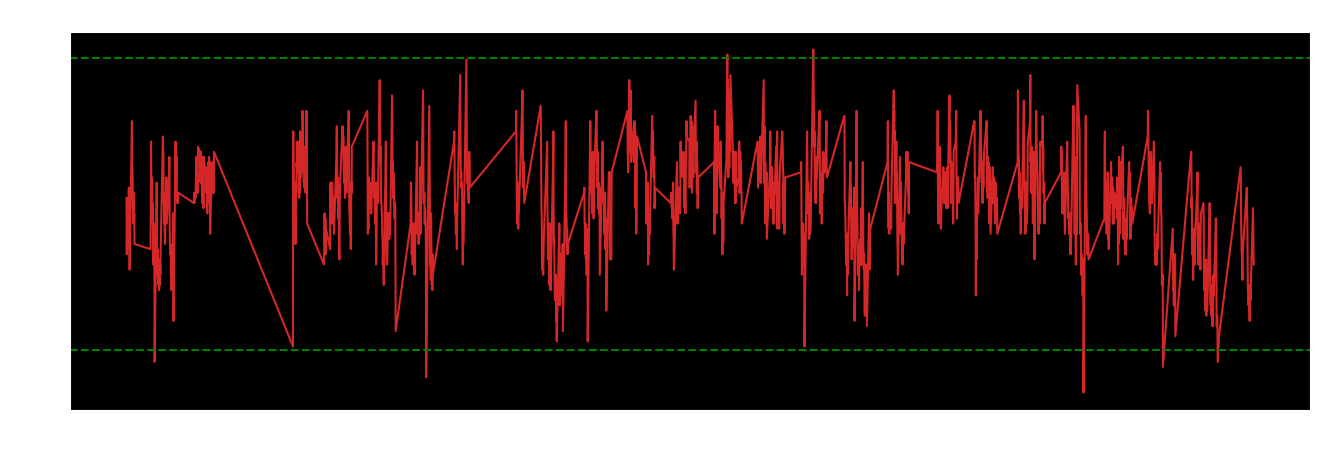

In [443]:
# Everything above or below the green bars is outside statistical normality
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_hour.index, df_hour['acceleration'], color='tab:red')
plt.axhline(y=df_hour['acceleration'].mean()+3*df_hour['acceleration'].std(), color='green',ls= '--')
plt.axhline(y=df_hour['acceleration'].mean()-3*df_hour['acceleration'].std(), color='green',ls= '--')

plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

In [444]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='weekday', y='acceleration', data=df_hour, ax=axes[0])
sns.boxplot(x='month', y='acceleration', data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :])

# Set Title
axes[0].set_title('weekday Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

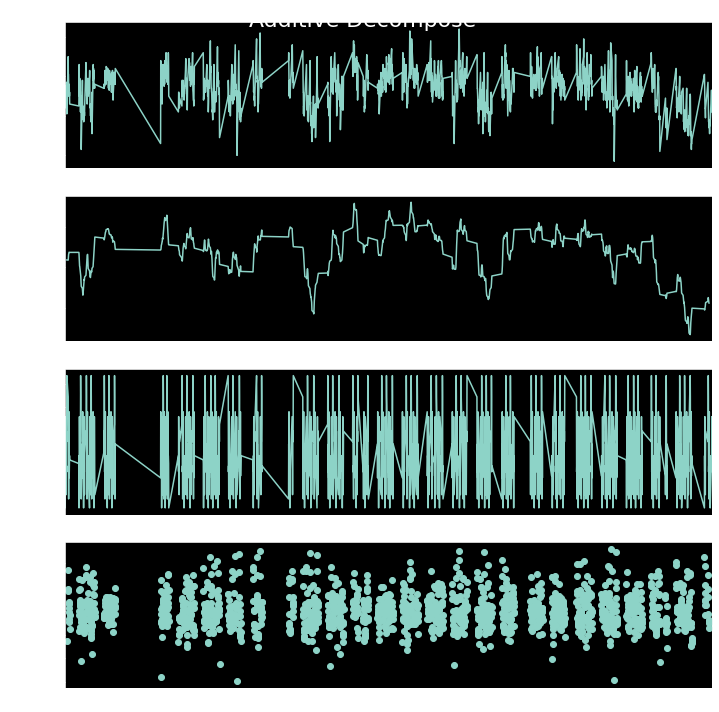

In [445]:
#Lets do some seasonality calculation adn division, we can start with additive time series
# Value = Base Level + Trend + Seasonality + Error

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_hour['acceleration'], model='multiplicative', period=24)

# Additive Decomposition
result_add = seasonal_decompose(df_hour['acceleration'], model='additive', period=24)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [446]:
result = adfuller(df_hour.acceleration.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_hour.acceleration.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.906213013473227
p-value: 3.391613007292282e-05
Critial Values:
   1%, -3.4343880265995215
Critial Values:
   5%, -2.8633235546096194
Critial Values:
   10%, -2.56771952639493

KPSS Statistic: 0.607350
p-value: 0.021968
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


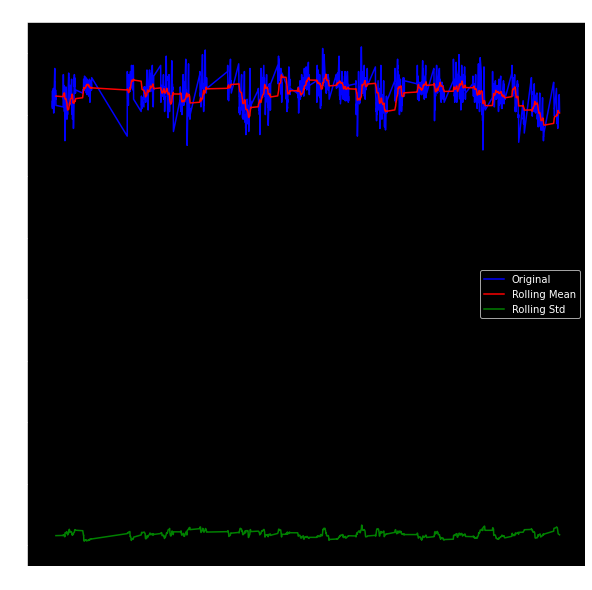

Results of Dickey-Fuller Test:


Test Statistic                   -4.906213
p-value                           0.000034
#Lags Used                       15.000000
Number of Observations Used    1622.000000
Critical Value (1%)              -3.434388
Critical Value (5%)              -2.863324
Critical Value (10%)             -2.567720
dtype: float64

In [447]:
#Determing rolling statistics to check for stationarity
rolmean = df_hour['acceleration'].rolling(24).mean()
rolstd = df_hour['acceleration'].rolling(24).std()
#Plot rolling statistics:
plt.plot(df_hour['acceleration'], color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_hour['acceleration'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

In [448]:
smooth_df_hour=df_hour['acceleration']-rolmean
smooth_df_hour.dropna(inplace=True)
smooth_df_hour


Time
2021-12-10 16:00:00   -0.302083
2021-12-13 06:00:00   -0.331250
2021-12-13 07:00:00    0.002083
2021-12-13 08:00:00    0.666667
2021-12-13 09:00:00    0.335417
                         ...   
2022-06-08 21:00:00   -0.231250
2022-06-09 06:00:00    0.579167
2022-06-09 07:00:00    0.333333
2022-06-09 08:00:00    0.141667
2022-06-09 09:00:00    0.045833
Name: acceleration, Length: 1615, dtype: float64

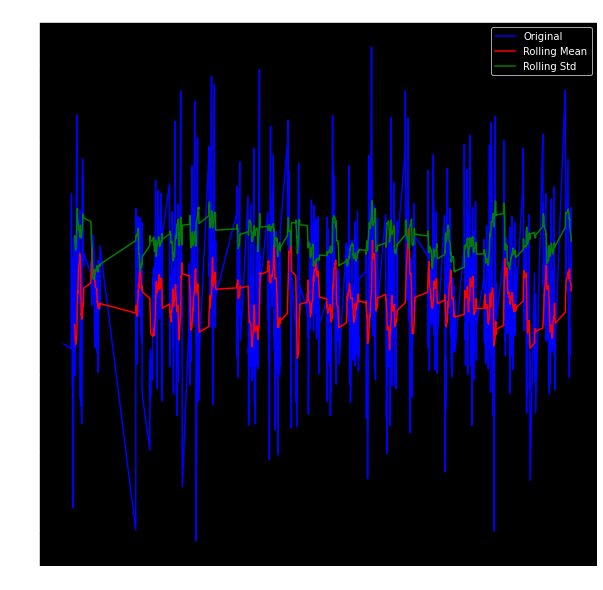

Results of Dickey-Fuller Test:


Test Statistic                -1.174391e+01
p-value                        1.254636e-21
#Lags Used                     2.000000e+01
Number of Observations Used    1.594000e+03
Critical Value (1%)           -3.434459e+00
Critical Value (5%)           -2.863355e+00
Critical Value (10%)          -2.567736e+00
dtype: float64

In [449]:
#Determing rolling statistics to check for stationarity
rolmean = smooth_df_hour.rolling(24).mean()
rolstd = smooth_df_hour.rolling(24).std()
#Plot rolling statistics:
plt.plot(smooth_df_hour, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(smooth_df_hour, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Text(0.5, 0.98, 'Decomposition')

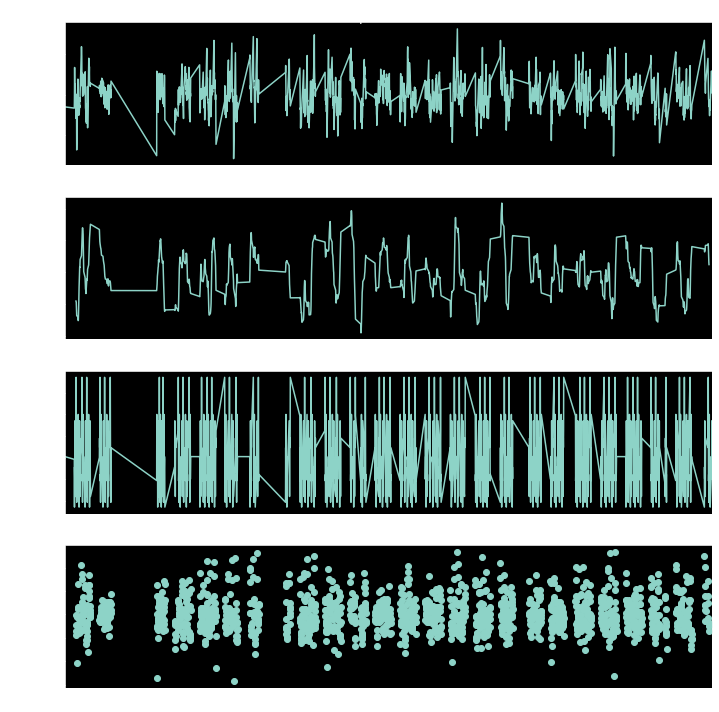

In [450]:
decomposition = seasonal_decompose(smooth_df_hour, period=24)
hour_trend = decomposition.trend
hour_seasonal = decomposition.seasonal
hour_residual = decomposition.resid
decomposition.plot().suptitle("Decomposition")

In [452]:
#Remove Night hours and weekends
df_hour_filtered = df.resample('H').median()
df_hour_filtered['weekday'] = [d.strftime('%a') for d in df_hour_filtered.index]
df_hour_filtered['hour'] = [d.strftime('%H') for d in df_hour_filtered.index]
df_hour_filtered['yearweek'] = [d.strftime('%W') for d in df_hour_filtered.index]
df_hour_filtered['month'] = [d.strftime('%b') for d in df_hour_filtered.index]
df_hour_filtered['yearday'] = [d.strftime('%j') for d in df_hour_filtered.index]
df_hour_filtered['year'] = [d.strftime('%Y') for d in df_hour_filtered.index]
df_hour_filtered['hour']=df_hour_filtered['hour'].astype(int)
df_hour_filtered = df_hour_filtered[~df_hour_filtered['weekday'].isin(['Sat', 'Sun'])]
df_hour_filtered = df_hour_filtered[~df_hour_filtered['hour'].isin([21,22,23,0,1,2,3,4,5,6])]
#We can also check what other days have deviations
outlier_day_df = df_hour_filtered.loc[df_hour_filtered['acceleration']<12]
outlier_days = outlier_day_df['yearday'].unique()
outlier_days

array(['344', '351', '357', '358', '361', '362', '363', '364', '365',
       '003', '004', '007', '010', '014', '026', '028', '031', '032',
       '033', '034', '035', '038', '039', '040', '041', '042', '049',
       '054', '056', '059', '060', '061', '063', '066', '070', '077',
       '080', '081', '084', '091', '098', '104', '105', '108', '112',
       '119', '126', '131', '133', '140', '145', '146', '147', '154',
       '157', '158'], dtype=object)

In [453]:
df_hour_filtered

acceleration weekday  hour yearweek month yearday  year
Time                                                                        
2021-12-09 09:00:00         14.75     Thu     9       49   Dec     343  2021
2021-12-09 10:00:00         14.20     Thu    10       49   Dec     343  2021
2021-12-09 11:00:00         14.45     Thu    11       49   Dec     343  2021
2021-12-09 12:00:00         14.25     Thu    12       49   Dec     343  2021
2021-12-09 13:00:00         14.45     Thu    13       49   Dec     343  2021
...                           ...     ...   ...      ...   ...     ...   ...
2022-06-08 19:00:00         13.90     Wed    19       23   Jun     159  2022
2022-06-08 20:00:00         13.75     Wed    20       23   Jun     159  2022
2022-06-09 07:00:00         14.40     Thu     7       23   Jun     160  2022
2022-06-09 08:00:00         14.20     Thu     8       23   Jun     160  2022
2022-06-09 09:00:00         14.10     Thu     9       23   Jun     160  2022

[1821 rows x 7 columns]

In [454]:
# We could remove these days completely to have a clean dataset with a correct periodicity
df_hour_filtered = df_hour_filtered[~df_hour_filtered['yearday'].isin(outlier_days)]
rolmean_df_hour_filtered = df_hour_filtered['acceleration'].rolling(50).mean()
rolstd_df_hour_filtered = df_hour_filtered['acceleration'].rolling(50).std()
higher_bound = rolmean_df_hour_filtered + 3 *rolstd_df_hour_filtered 
lower_bound = rolmean_df_hour_filtered - 3 *rolstd_df_hour_filtered 


In [455]:
#In this section // test part we remove the datetime index and just add a serial
df_test=df_hour_filtered.copy()
df_test.reset_index(inplace=True)
df_test

Time  acceleration weekday  hour yearweek month yearday  \
0    2021-12-09 09:00:00         14.75     Thu     9       49   Dec     343   
1    2021-12-09 10:00:00         14.20     Thu    10       49   Dec     343   
2    2021-12-09 11:00:00         14.45     Thu    11       49   Dec     343   
3    2021-12-09 12:00:00         14.25     Thu    12       49   Dec     343   
4    2021-12-09 13:00:00         14.45     Thu    13       49   Dec     343   
...                  ...           ...     ...   ...      ...   ...     ...   
1032 2022-06-08 19:00:00         13.90     Wed    19       23   Jun     159   
1033 2022-06-08 20:00:00         13.75     Wed    20       23   Jun     159   
1034 2022-06-09 07:00:00         14.40     Thu     7       23   Jun     160   
1035 2022-06-09 08:00:00         14.20     Thu     8       23   Jun     160   
1036 2022-06-09 09:00:00         14.10     Thu     9       23   Jun     160   

      year  
0     2021  
1     2021  
2     2021  
3     2021  
4     2021  
...    ...  
1032  2022  
1033  2022  
1034  2022  
1035  2022  
1036  2022  

[1037 rows x 8 columns]

In [456]:
rolmean_df_test = df_test['acceleration'].rolling(50).mean()
rolstd_df_test = df_test['acceleration'].rolling(50).std()
higher_bound = rolmean_df_test + 3 *rolstd_df_test 
lower_bound = rolmean_df_test - 3 *rolstd_df_test 

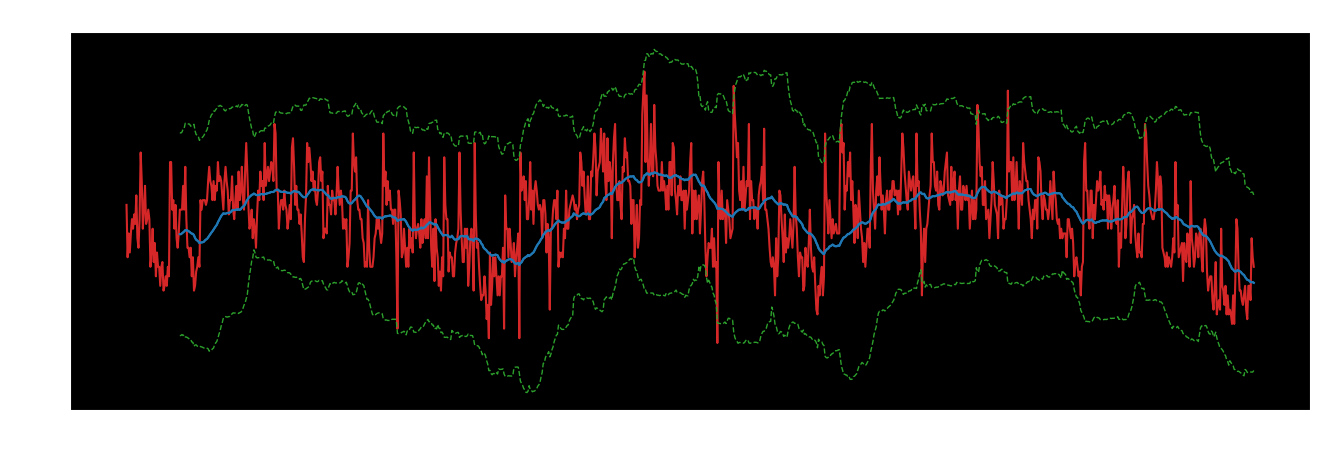

In [457]:
#plot them with boundries on top of 3 standard deviations
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_test.index, df_test['acceleration'], color='tab:red')
plt.plot(df_test.index, rolmean_df_test, color='tab:blue')
plt.plot(df_test.index, rolmean_df_test, color='tab:blue')
plt.plot(df_test.index, higher_bound, color='tab:green', ls='--', linewidth = 1)
plt.plot(df_test.index, lower_bound, color='tab:green', ls='--', linewidth = 1)
plt.plot
plt.gca().set(title='acceleration with 3 std boundries', xlabel='date', ylabel='m/s2')
plt.show()

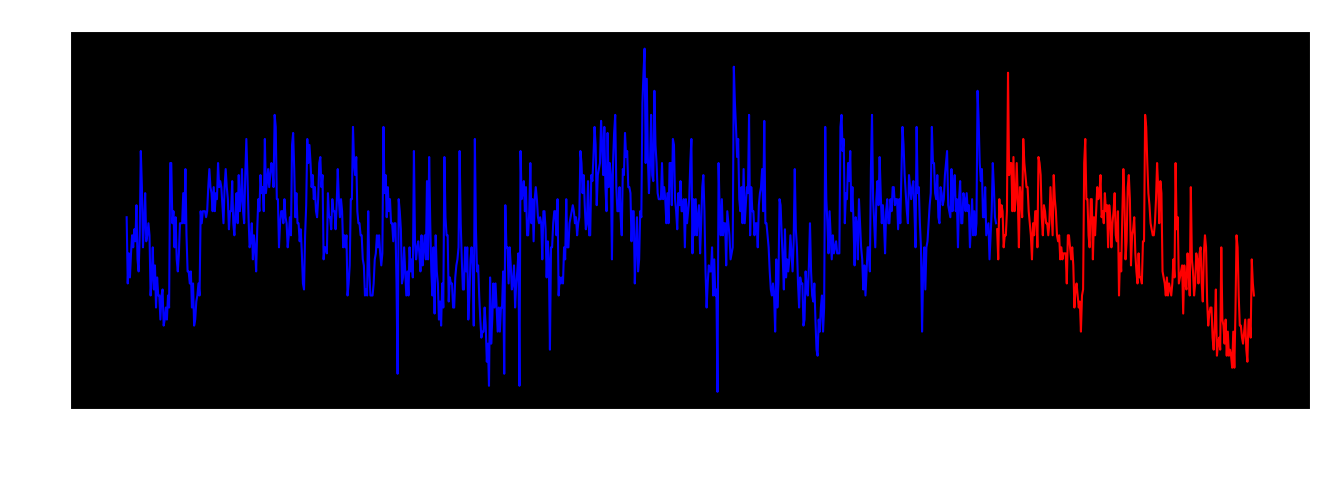

In [458]:
#Create a test and train sample
test_acceleration=df_test['acceleration']
df_test_train = test_acceleration[test_acceleration.index < 800]
df_test_test = test_acceleration[test_acceleration.index >= 800]
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_test_train ,color = "blue")
plt.plot(df_test_test, color = "red")
plt.ylabel('df_acceleration Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for df_acceleration Data")
plt.show()

In [459]:
# decomposition = seasonal_decompose(df_test_train)
rolmean= df_test_train.rolling(14).mean()
rolstd = df_test_train.rolling(14).std()
#Plot rolling statistics:
plt.plot(df_test_train, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_test_train, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
#ITs stationary because
# • test statistic is lower than 1% critical values.

# • the mean and std variations have small variations with time.
#the p value is very low

Results of Dickey-Fuller Test:
Test Statistic                  -4.224332
p-value                          0.000599
#Lags Used                      14.000000
Number of Observations Used    785.000000
Critical Value (1%)             -3.438708
Critical Value (5%)             -2.865229
Critical Value (10%)            -2.568734
dtype: float64


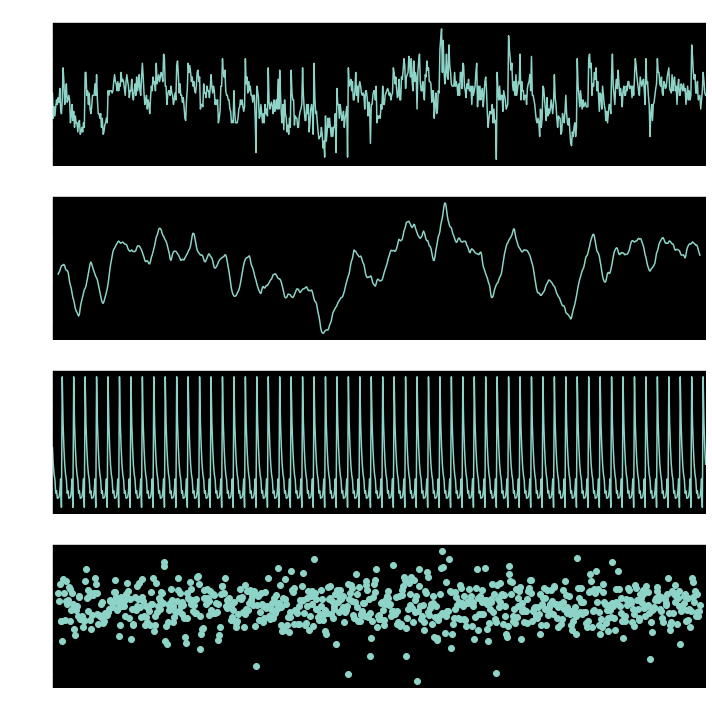

In [460]:
# If our line was not stationary we would decompose, but its not needed in this case
decomposition = seasonal_decompose(df_test_train, period = 14)
decomposition.plot()

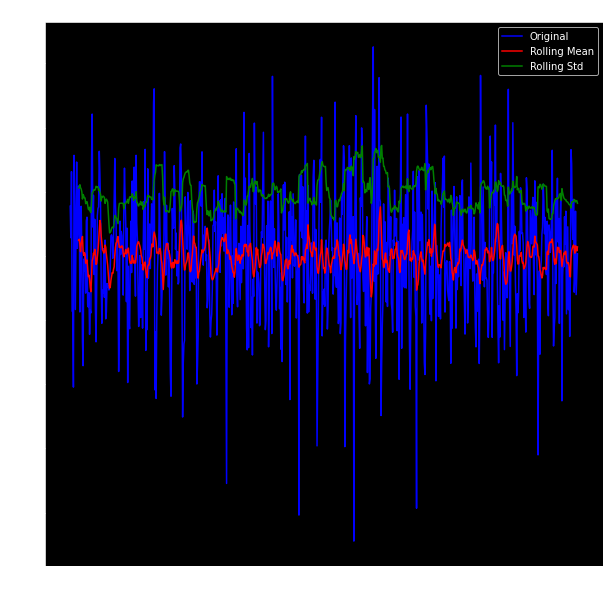

Results of Dickey-Fuller Test:
Test Statistic                -1.104545e+01
p-value                        5.237282e-20
#Lags Used                     1.900000e+01
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [461]:
#Lets use the residual
y_train_residual = decomposition.resid
y_train_residual.dropna(inplace=True)
rolmean= y_train_residual.rolling(14).mean()
rolstd = y_train_residual.rolling(14).std()
#Plot rolling statistics:
plt.plot(y_train_residual, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y_train_residual, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

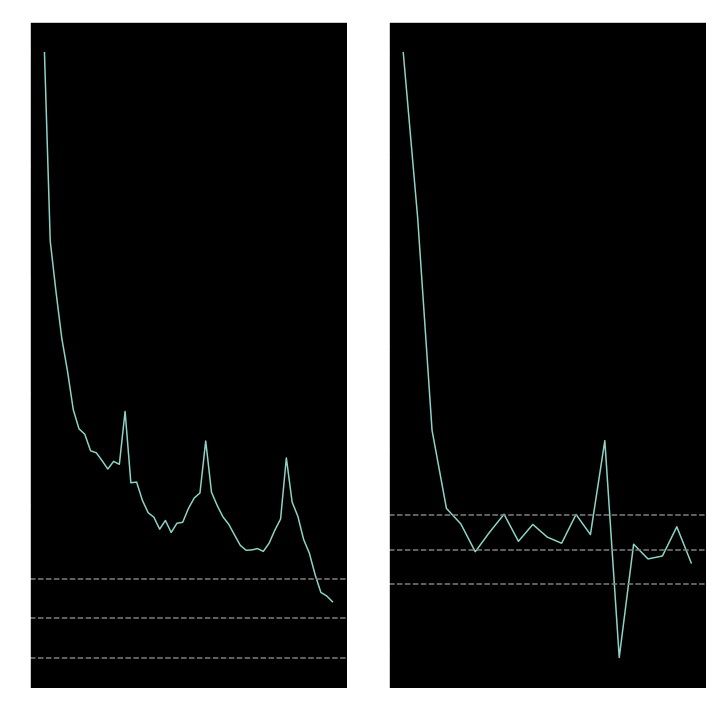

In [462]:
# Now that we have made the Time series stationary, 
# let’s make models on the time series using differencing because it is easy to add the error , trend and seasonality back into predicted values .
# We will use statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.
# Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .
# • p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).

# • q : This is the number of MA (Moving-Average) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).

# • d :This is the number of differences or the number of non-seasonal differences .
# P = lags in the autoregressive model.
# D = differencing / integration order.
# Q =  moving average lags

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_test_train, nlags=50)
lag_pacf = pacf(df_test_train, nlags=20)

#Plot
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, ls='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_test_train)), ls='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_test_train)), ls='--', color='gray')
plt.title('Autocorrelation function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, ls='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_test_train)), ls='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_test_train)), ls='--', color='gray')
plt.title('Partial Autocorrelation function')
plt.tight_layout()
# • p: The first time where the PACF crosses the upper confidence interval,

# • q: The first time where the ACF crosses the upper confidence interval

In [463]:
model= ARIMA(df_test_train, order = (10,0,3))
results_ARIMA = model.fit()
plt.figure(figsize=(16,5))
plt.plot(df_test_train, color = 'green')
plt.plot(results_ARIMA.fittedvalues,color= 'red')
plt.title(f'RSS:{sum(results_ARIMA.fittedvalues-df_test_train)**2}')

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS:0.010308447771585239')

In [464]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           acceleration   No. Observations:                  800
Model:                ARIMA(10, 0, 3)   Log Likelihood                -169.304
Date:                Tue, 28 Jun 2022   AIC                            368.608
Time:                        15:33:48   BIC                            438.877
Sample:                             0   HQIC                           395.602
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6941      0.116    126.248      0.000      14.466      14.922
ar.L1         -0.2636      0.058     -4.562      0.000      -0.377      -0.150
ar.L2          1.2679      0.067     19.006      0.000       1.137       1.399
ar.L3          0.6534      0.070      9.300      0.000       0.516       0.791
ar.L4         -0.4385      0.074     -5.947      0.000      -0.583      -0.294
ar.L5         -0.1894      0.071     -2.679      0.007      -0.328      -0.051
ar.L6         -0.0978      0.070     -1.394      0.163      -0.235       0.040
ar.L7          0.0709      0.073      0.974      0.330      -0.072       0.214
ar.L8         -0.0158      0.070     -0.224      0.822      -0.154       0.122
ar.L9         -0.0664      0.046     -1.451      0.147      -0.156       0.023
ar.L10         0.0618      0.045      1.365      0.172      -0.027       0.150
ma.L1          0.7763      0.052     14.975      0.000       0.675       0.878
ma.L2         -0.7327      0.061    -11.953      0.000      -0.853      -0.613
ma.L3         -0.8638      0.050    -17.117      0.000      -0.963      -0.765
sigma2         0.0890      0.004     23.973      0.000       0.082       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               283.36
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.79
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [465]:
#Predict with the test set
prediction = results_ARIMA.get_forecast(len(df_test_test.index))
prediction_df = prediction.conf_int(alpha = 0.05) 
prediction_df["Predictions"] = results_ARIMA.predict(start = prediction_df.index[0], end = prediction_df.index[-1])
prediction_df.index = df_test_test.index
prediction_out = prediction_df["Predictions"]
arma_rmse = np.sqrt(mean_squared_error(df_test_test.values, prediction_df["Predictions"]))
print("RMSE: ",arma_rmse)


RMSE:  0.49556588360943177


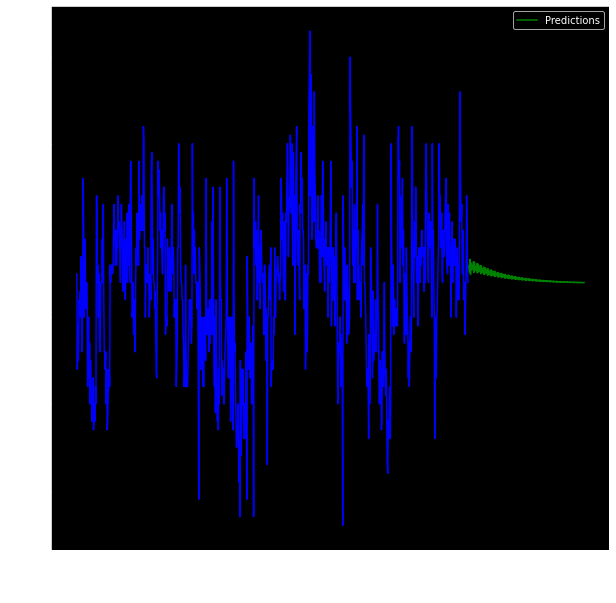

In [466]:
#Plot
plt.plot(prediction_out, color='green', label = 'Predictions')
plt.plot(df_test_train ,color = "blue")
# plt.plot(df_test_test, color = "red")
plt.ylabel('df_acceleration Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS:0.001082584118947336')

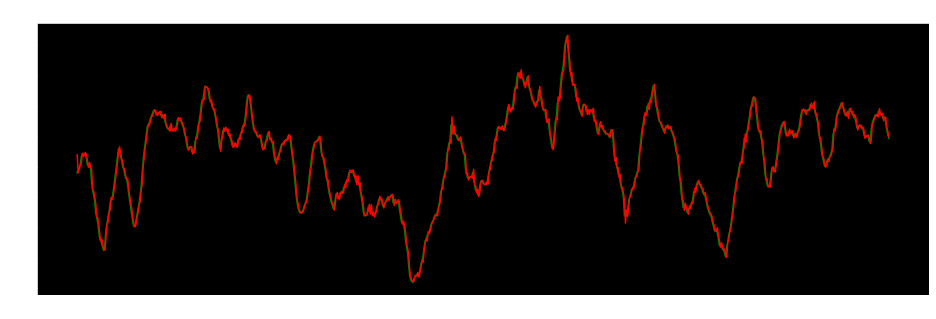

In [467]:
#same but with rolmean
rolmean= df_test_train.rolling(14).mean()
rolmean.dropna(inplace=True)
model_rolmean= ARIMA(rolmean, order = (1,0,1))
results_ARIMA_roling = model_rolmean.fit()
plt.figure(figsize=(16,5))
plt.plot(rolmean, color = 'green')
plt.plot(results_ARIMA_roling.fittedvalues,color= 'red')
plt.title(f'RSS:{sum(results_ARIMA_roling.fittedvalues-rolmean)**2}')

In [468]:
#Predict with the test set
prediction_rolmean = results_ARIMA_roling.get_forecast(len(df_test_test.index))
prediction_rolmean_df = prediction_rolmean.conf_int(alpha = 0.05) 
prediction_rolmean_df["prediction_rolmeans"] = results_ARIMA_roling.predict(start = prediction_rolmean_df.index[0], end = prediction_rolmean_df.index[-1])
prediction_rolmean_df.index = df_test_test.index
prediction_rolmean_out = prediction_rolmean_df["prediction_rolmeans"]
arma_rmse_rolmean = np.sqrt(mean_squared_error(df_test_test.values, prediction_rolmean_df["prediction_rolmeans"]))
print("RMSE: ",arma_rmse_rolmean)

RMSE:  0.4909532085332958


c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


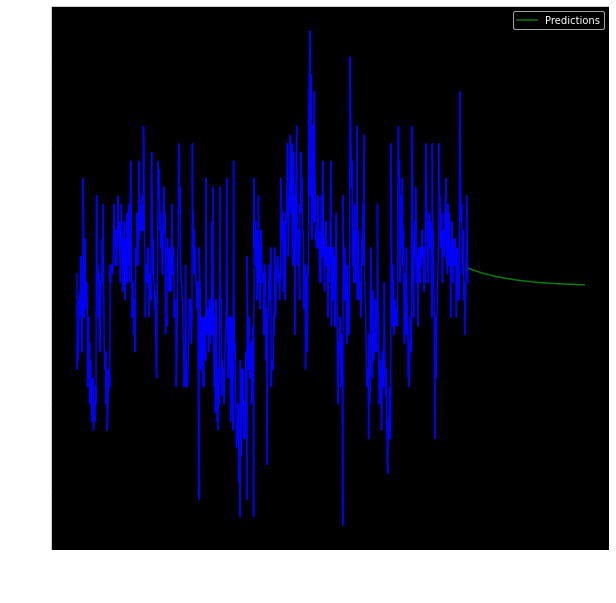

In [469]:
#Plot
plt.plot(prediction_rolmean_out, color='green', label = 'Predictions')
plt.plot(df_test_train ,color = "blue")
# plt.plot(df_test_test, color = "red")
plt.ylabel('df_acceleration Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

In [470]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# y=df_hour['acceleration']
y=df_test_train
ARMAmodel = SARIMAX(y, order = (2, 0, 1)) #seasonal_order=(1,1,1,14))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(df_test_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test_test.index
y_pred_out = y_pred_df["Predictions"] 
arma_rmse = np.sqrt(mean_squared_error(df_test_test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  0.42637898500581406


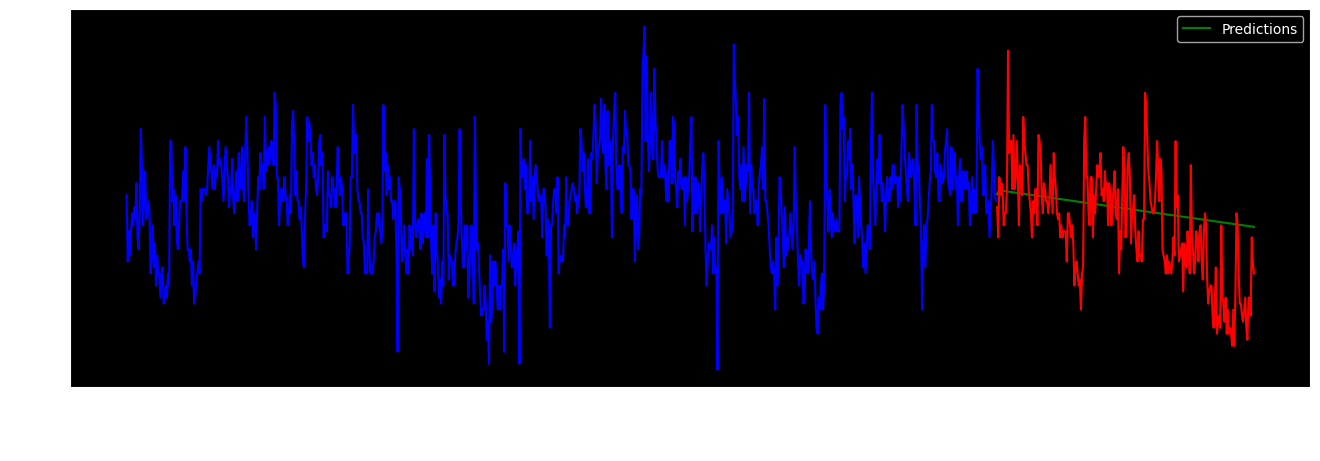

In [503]:
# Draw prediction
plt.figure(figsize=(16,5),dpi=100)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(df_test_train ,color = "blue")
plt.plot(df_test_test, color = "red")
plt.ylabel('df_acceleration Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

In [472]:
#We use our real data now
df_hour_reset_index=df_hour_filtered.copy()
df_hour_reset_index.reset_index(inplace=True)
model= ARIMA(df_hour_reset_index['acceleration'], order = (45,0,3))
ARIMA_model = model.fit()
plt.figure(figsize=(16,5))
plt.plot(df_hour_reset_index['acceleration'], color = 'green')
plt.plot(ARIMA_model.fittedvalues,color= 'red')
plt.title(f"RSS:{sum(ARIMA_model.fittedvalues-df_hour_reset_index['acceleration'])**2}")

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS:0.21279896525689868')

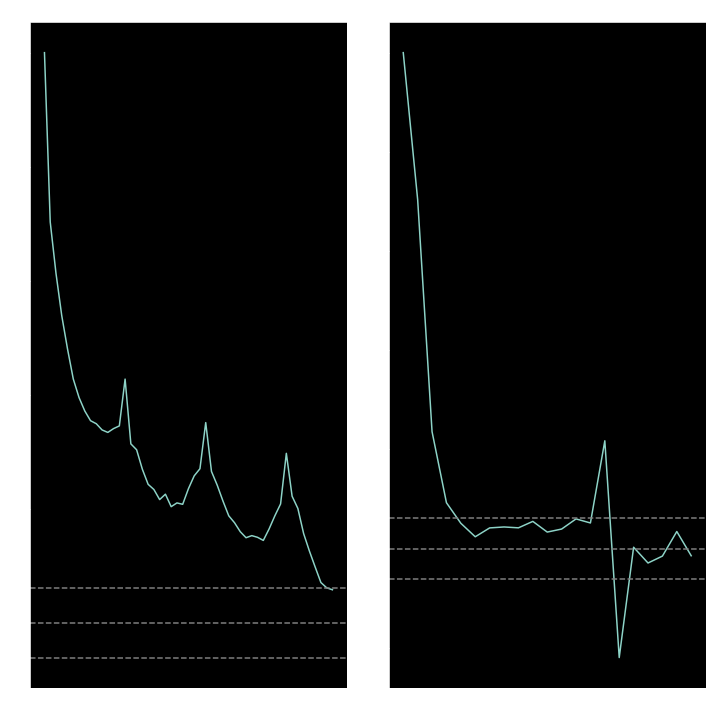

In [473]:
lag_acf = acf(df_hour_reset_index['acceleration'], nlags=50)
lag_pacf = pacf(df_hour_reset_index['acceleration'], nlags=20)

#Plot
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, ls='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_hour_reset_index['acceleration'])), ls='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_hour_reset_index['acceleration'])), ls='--', color='gray')
plt.title('Autocorrelation function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, ls='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_hour_reset_index['acceleration'])), ls='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_hour_reset_index['acceleration'])), ls='--', color='gray')
plt.title('Partial Autocorrelation function')
plt.tight_layout()

In [474]:
df_hour_reset_index.index

RangeIndex(start=0, stop=1037, step=1)

In [475]:
prediction = ARIMA_model.get_forecast(100)
prediction_df = prediction.conf_int(alpha = 0.05) 
prediction_df["predictions"] = ARIMA_model.predict(start = prediction_df.index[0], end = prediction_df.index[-1])
prediction_df.index = pd.RangeIndex(start=df_hour_reset_index.index[-1], stop=df_hour_reset_index.index[-1]+100, step=1)
prediction_out = prediction_df["predictions"]


Text(0.5, 1.0, 'Forecast for 100 values')

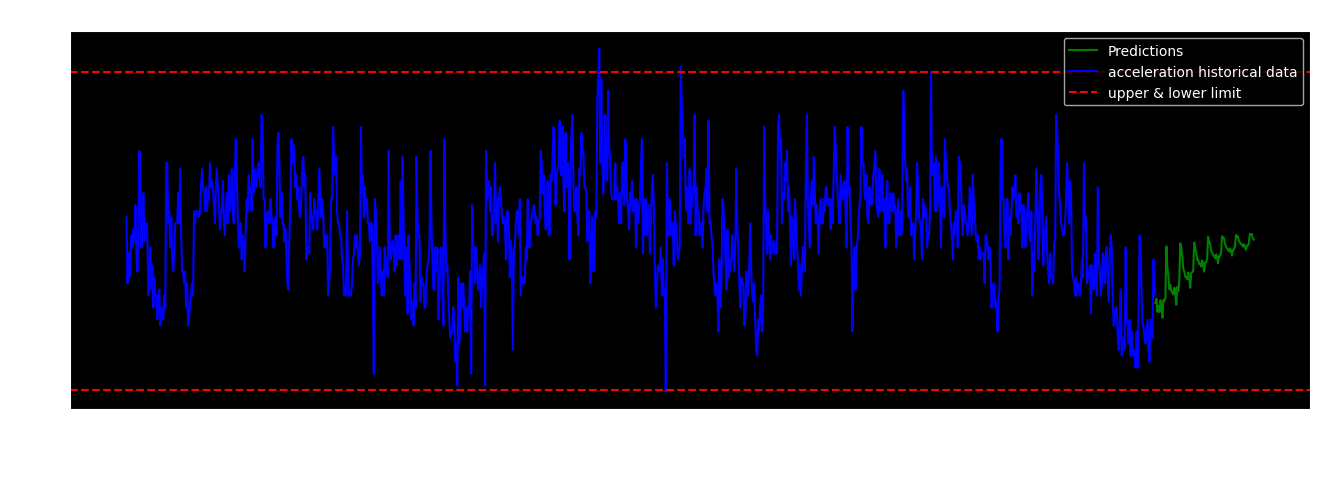

In [476]:
#Plot
plt.figure(figsize=(16,5), dpi=100)
plt.plot(prediction_out, color='green', label = 'Predictions')
plt.plot(df_hour_reset_index['acceleration'] ,color = "blue", label="acceleration historical data")
plt.axhline(y=df_hour_reset_index['acceleration'].mean()+3*df_hour_reset_index['acceleration'].std(), color='red',ls= '--', label="upper & lower limit")
plt.axhline(y=df_hour_reset_index['acceleration'].mean()-3*df_hour_reset_index['acceleration'].std(), color='red',ls= '--')
# plt.plot(df_test_test, color = "red")
plt.ylabel('acceleration')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title('Forecast for 100 values')

In [477]:
df_hour_reset_index.set_index('Time',inplace=True)
df_hour_reset_index
ts = pd.date_range('2022-06-09 09:00:00', freq='H', periods = 100)
ts
# predictions_date = DateOffset

DatetimeIndex(['2022-06-09 09:00:00', '2022-06-09 10:00:00',
               '2022-06-09 11:00:00', '2022-06-09 12:00:00',
               '2022-06-09 13:00:00', '2022-06-09 14:00:00',
               '2022-06-09 15:00:00', '2022-06-09 16:00:00',
               '2022-06-09 17:00:00', '2022-06-09 18:00:00',
               '2022-06-09 19:00:00', '2022-06-09 20:00:00',
               '2022-06-09 21:00:00', '2022-06-09 22:00:00',
               '2022-06-09 23:00:00', '2022-06-10 00:00:00',
               '2022-06-10 01:00:00', '2022-06-10 02:00:00',
               '2022-06-10 03:00:00', '2022-06-10 04:00:00',
               '2022-06-10 05:00:00', '2022-06-10 06:00:00',
               '2022-06-10 07:00:00', '2022-06-10 08:00:00',
               '2022-06-10 09:00:00', '2022-06-10 10:00:00',
               '2022-06-10 11:00:00', '2022-06-10 12:00:00',
               '2022-06-10 13:00:00', '2022-06-10 14:00:00',
               '2022-06-10 15:00:00', '2022-06-10 16:00:00',
               '2022-06-

In [478]:
predictions_date = prediction_out.copy()

In [479]:

# predictions_date = pd.concat([predictions_date,ts])
predictions_date = predictions_date.to_frame()



In [480]:
predictions_date.set_index(ts,inplace=True)
predictions_date

predictions
2022-06-09 09:00:00    14.038218
2022-06-09 10:00:00    14.072787
2022-06-09 11:00:00    13.964811
2022-06-09 12:00:00    14.012559
2022-06-09 13:00:00    13.963278
...                          ...
2022-06-13 08:00:00    14.610804
2022-06-13 09:00:00    14.605279
2022-06-13 10:00:00    14.609727
2022-06-13 11:00:00    14.576981
2022-06-13 12:00:00    14.564982

[100 rows x 1 columns]

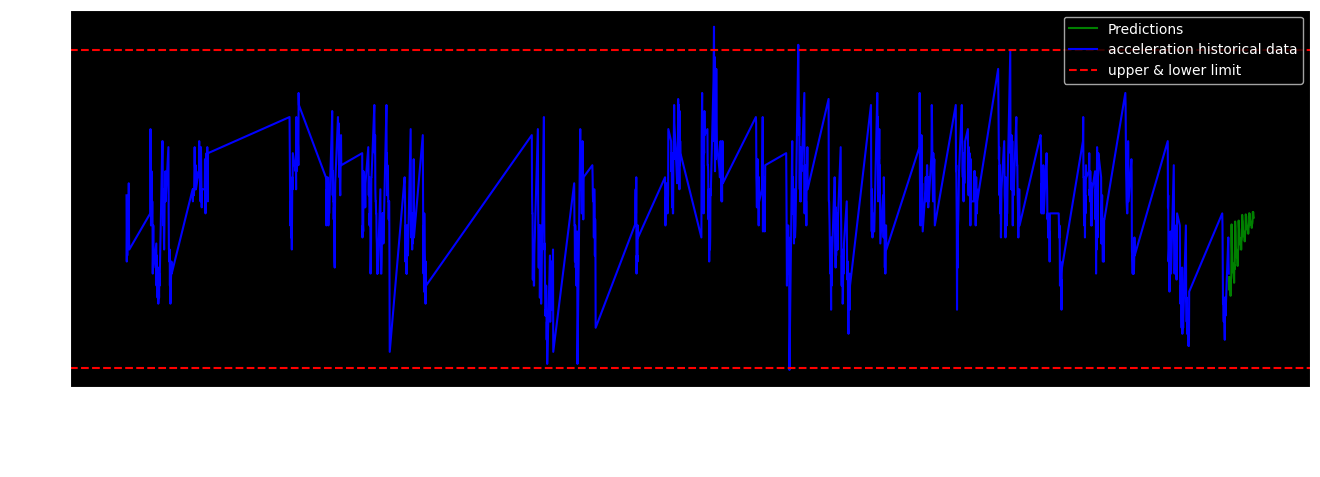

In [481]:
#Plot
plt.figure(figsize=(16,5), dpi=100)
plt.plot(predictions_date, color='green', label = 'Predictions')
plt.plot(df_hour_reset_index['acceleration'] ,color = "blue", label="acceleration historical data")
plt.axhline(y=df_hour_reset_index['acceleration'].mean()+3*df_hour_reset_index['acceleration'].std(), color='red',ls= '--', label="upper & lower limit")
plt.axhline(y=df_hour_reset_index['acceleration'].mean()-3*df_hour_reset_index['acceleration'].std(), color='red',ls= '--')
# plt.plot(df_test_test, color = "red")
plt.ylabel('acceleration')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS:38.03649242595889')

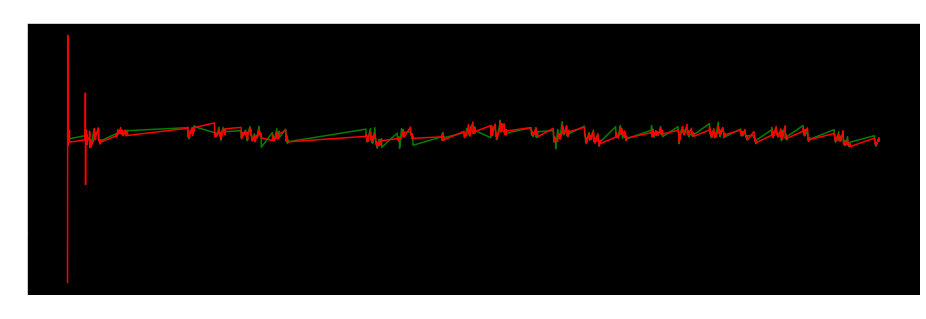

In [482]:
y=df_hour_reset_index['acceleration']
ARMAmodel = SARIMAX(y, order = (1, 2, 1) ,seasonal_order=(1,1,1,14))
SARIMAX_model = ARMAmodel.fit()
plt.figure(figsize=(16,5))
plt.plot(df_hour_reset_index['acceleration'], color = 'green')
plt.plot(SARIMAX_model.fittedvalues,color= 'red')
plt.title(f"RSS:{sum(SARIMAX_model.fittedvalues-df_hour_reset_index['acceleration'])**2}")

In [483]:
# We will use now our ARIMA and SARIMA and train on the complete dataset
from pandas.tseries.offsets import DateOffset

In [484]:
#Do the same but just setting the index
df_string= df_hour_filtered.copy()
df_string.index = df_string.index.strftime('%m/%d/%Y, %H')
df_string.index

Index(['12/09/2021, 09', '12/09/2021, 10', '12/09/2021, 11', '12/09/2021, 12',
       '12/09/2021, 13', '12/09/2021, 14', '12/09/2021, 15', '12/09/2021, 16',
       '12/09/2021, 17', '12/09/2021, 18',
       ...
       '06/08/2022, 14', '06/08/2022, 15', '06/08/2022, 16', '06/08/2022, 17',
       '06/08/2022, 18', '06/08/2022, 19', '06/08/2022, 20', '06/09/2022, 07',
       '06/09/2022, 08', '06/09/2022, 09'],
      dtype='object', name='Time', length=1037)

In [485]:
rolmean_df_string = df_string['acceleration'].rolling(50).mean()
rolstd_df_string = df_string['acceleration'].rolling(50).std()
higher_bound = rolmean_df_string + 3 *rolstd_df_string 
lower_bound = rolmean_df_string - 3 *rolstd_df_string 

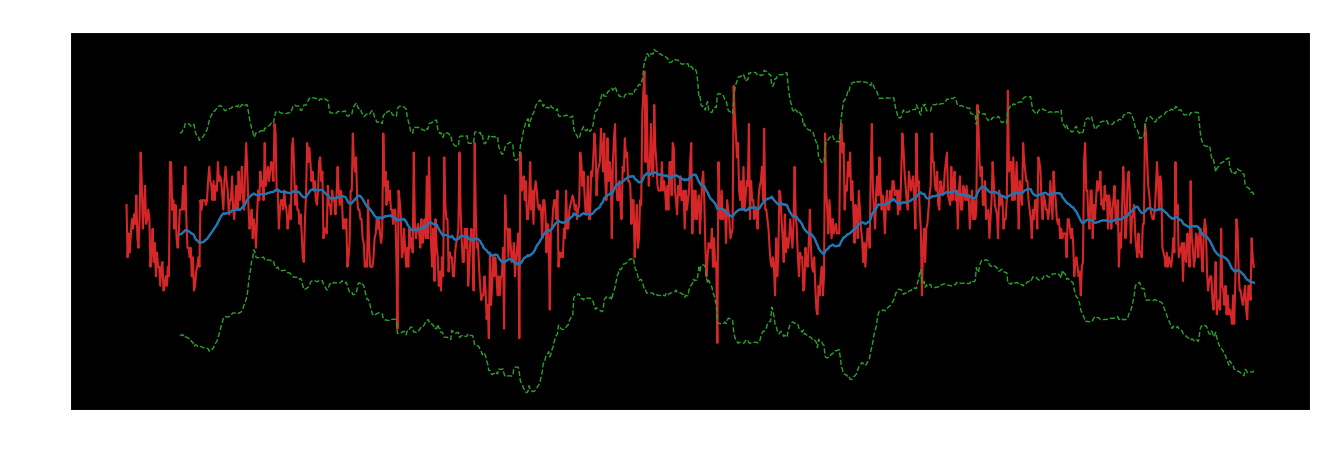

In [486]:
#plot them with boundries on top of 3 standard deviations
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_string.index, df_string['acceleration'], color='tab:red')
plt.plot(df_string.index, rolmean_df_string, color='tab:blue')
plt.plot(df_string.index, rolmean_df_string, color='tab:blue')
plt.plot(df_string.index, higher_bound, color='tab:green', ls='--', linewidth = 1)
plt.plot(df_string.index, lower_bound, color='tab:green', ls='--', linewidth = 1)
plt.plot
plt.gca().set(title='acceleration with 3 std boundries', xlabel='date', ylabel='m/s2')
plt.show()

In [504]:
df_hour_reset_index

acceleration weekday  hour yearweek month yearday  year
Time                                                                        
2021-12-09 09:00:00         14.75     Thu     9       49   Dec     343  2021
2021-12-09 10:00:00         14.20     Thu    10       49   Dec     343  2021
2021-12-09 11:00:00         14.45     Thu    11       49   Dec     343  2021
2021-12-09 12:00:00         14.25     Thu    12       49   Dec     343  2021
2021-12-09 13:00:00         14.45     Thu    13       49   Dec     343  2021
...                           ...     ...   ...      ...   ...     ...   ...
2022-06-08 19:00:00         13.90     Wed    19       23   Jun     159  2022
2022-06-08 20:00:00         13.75     Wed    20       23   Jun     159  2022
2022-06-09 07:00:00         14.40     Thu     7       23   Jun     160  2022
2022-06-09 08:00:00         14.20     Thu     8       23   Jun     160  2022
2022-06-09 09:00:00         14.10     Thu     9       23   Jun     160  2022

[1037 rows x 7 columns]

The idea is the following: lets use daily values to spot trends. Lets take means or median of day values. And the days that have 0 lets give them the same value as the previous day. And try to predict from there

In [487]:
# Do test but with day values
#lets try filtering out cero values in advance
df_filtered=df[df['acceleration']>10]
df_day = df_filtered.resample('d').mean()
df_day['weekday'] = [d.strftime('%a') for d in df_day.index]
df_day['day'] = [d.strftime('%H') for d in df_day.index]
df_day['yearweek'] = [d.strftime('%W') for d in df_day.index]
df_day['month'] = [d.strftime('%b') for d in df_day.index]
df_day['yearday'] = [d.strftime('%j') for d in df_day.index]
df_day['year'] = [d.strftime('%Y') for d in df_day.index]
df_day['day']=df_day['day'].astype(int)

In [488]:
df_day['acceleration'].isnull().values.sum()

71

In [489]:
#Explore weekends
weekends_perday = df_day[df_day['weekday'].isin(['Sat' , 'Sun'])]
weekends_perday

acceleration weekday  day yearweek month yearday  year
Time                                                              
2021-12-11           NaN     Sat    0       49   Dec     345  2021
2021-12-12           NaN     Sun    0       49   Dec     346  2021
2021-12-18           NaN     Sat    0       50   Dec     352  2021
2021-12-19           NaN     Sun    0       50   Dec     353  2021
2021-12-25           NaN     Sat    0       51   Dec     359  2021
2021-12-26           NaN     Sun    0       51   Dec     360  2021
2022-01-01           NaN     Sat    0       00   Jan     001  2022
2022-01-02           NaN     Sun    0       00   Jan     002  2022
2022-01-08           NaN     Sat    0       01   Jan     008  2022
2022-01-09           NaN     Sun    0       01   Jan     009  2022
2022-01-15           NaN     Sat    0       02   Jan     015  2022
2022-01-16           NaN     Sun    0       02   Jan     016  2022
2022-01-22           NaN     Sat    0       03   Jan     022  2022
2022-01-23           NaN     Sun    0       03   Jan     023  2022
2022-01-29           NaN     Sat    0       04   Jan     029  2022
2022-01-30           NaN     Sun    0       04   Jan     030  2022
2022-02-05           NaN     Sat    0       05   Feb     036  2022
2022-02-06           NaN     Sun    0       05   Feb     037  2022
2022-02-12           NaN     Sat    0       06   Feb     043  2022
2022-02-13           NaN     Sun    0       06   Feb     044  2022
2022-02-19           NaN     Sat    0       07   Feb     050  2022
2022-02-20           NaN     Sun    0       07   Feb     051  2022
2022-02-26           NaN     Sat    0       08   Feb     057  2022
2022-02-27           NaN     Sun    0       08   Feb     058  2022
2022-03-05           NaN     Sat    0       09   Mar     064  2022
2022-03-06           NaN     Sun    0       09   Mar     065  2022
2022-03-12           NaN     Sat    0       10   Mar     071  2022
2022-03-13           NaN     Sun    0       10   Mar     072  2022
2022-03-19           NaN     Sat    0       11   Mar     078  2022
2022-03-20           NaN     Sun    0       11   Mar     079  2022
2022-03-26           NaN     Sat    0       12   Mar     085  2022
2022-03-27           NaN     Sun    0       12   Mar     086  2022
2022-04-02           NaN     Sat    0       13   Apr     092  2022
2022-04-03           NaN     Sun    0       13   Apr     093  2022
2022-04-09           NaN     Sat    0       14   Apr     099  2022
2022-04-10           NaN     Sun    0       14   Apr     100  2022
2022-04-16           NaN     Sat    0       15   Apr     106  2022
2022-04-17           NaN     Sun    0       15   Apr     107  2022
2022-04-23           NaN     Sat    0       16   Apr     113  2022
2022-04-24           NaN     Sun    0       16   Apr     114  2022
2022-04-30           NaN     Sat    0       17   Apr     120  2022
2022-05-01           NaN     Sun    0       17   May     121  2022
2022-05-07           NaN     Sat    0       18   May     127  2022
2022-05-08           NaN     Sun    0       18   May     128  2022
2022-05-14           NaN     Sat    0       19   May     134  2022
2022-05-15           NaN     Sun    0       19   May     135  2022
2022-05-21           NaN     Sat    0       20   May     141  2022
2022-05-22           NaN     Sun    0       20   May     142  2022
2022-05-28           NaN     Sat    0       21   May     148  2022
2022-05-29           NaN     Sun    0       21   May     149  2022
2022-06-04           NaN     Sat    0       22   Jun     155  2022
2022-06-05           NaN     Sun    0       22   Jun     156  2022

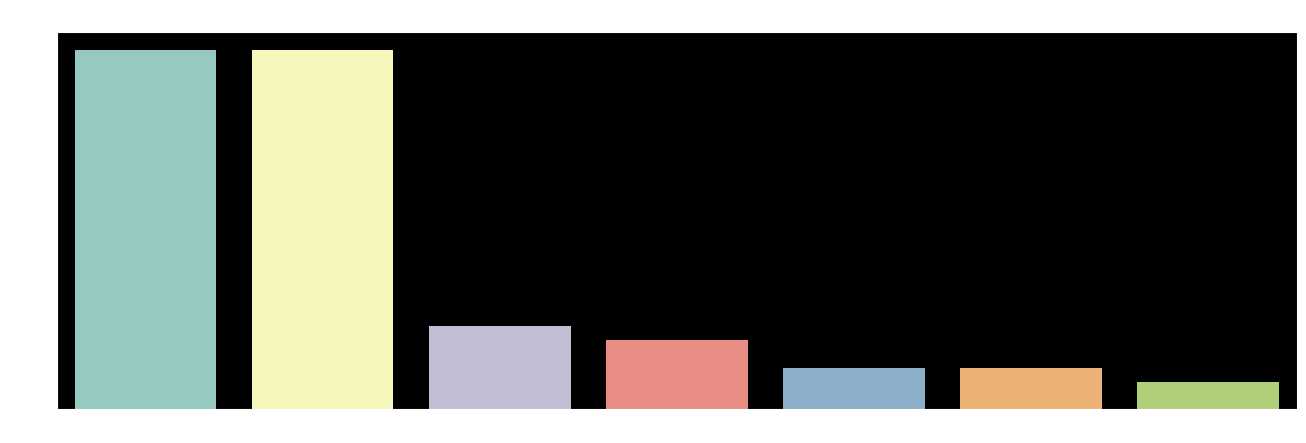

In [490]:
# Lets Check the emtpy values
empty_list = df_day[df_day['acceleration'].isnull()]
y = empty_list['weekday'].value_counts()
x = empty_list['weekday'].unique()
plt.figure(figsize=(16,5), dpi=100)
sns.barplot(x=x, y=y)
plt.title('Days with 0 values in acceleration')
plt.show()


In [491]:
df_day['acceleration']

Time
2021-12-09    14.614485
2021-12-10    14.880271
2021-12-11          NaN
2021-12-12          NaN
2021-12-13    14.618548
                ...    
2022-06-05          NaN
2022-06-06          NaN
2022-06-07    14.468827
2022-06-08    14.100000
2022-06-09    14.437168
Freq: D, Name: acceleration, Length: 183, dtype: float64

In [492]:
df_day_filled = df_day['acceleration'].fillna(method='ffill')


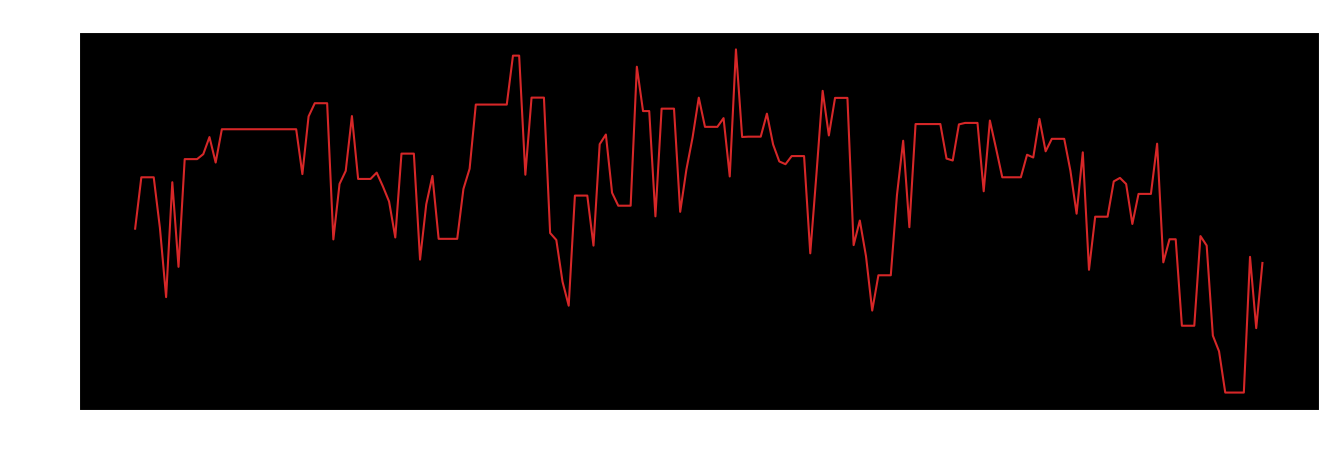

In [493]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_day_filled.index, df_day_filled, color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

In [494]:
df_day_filtered=df_day[df_day['acceleration']>8]

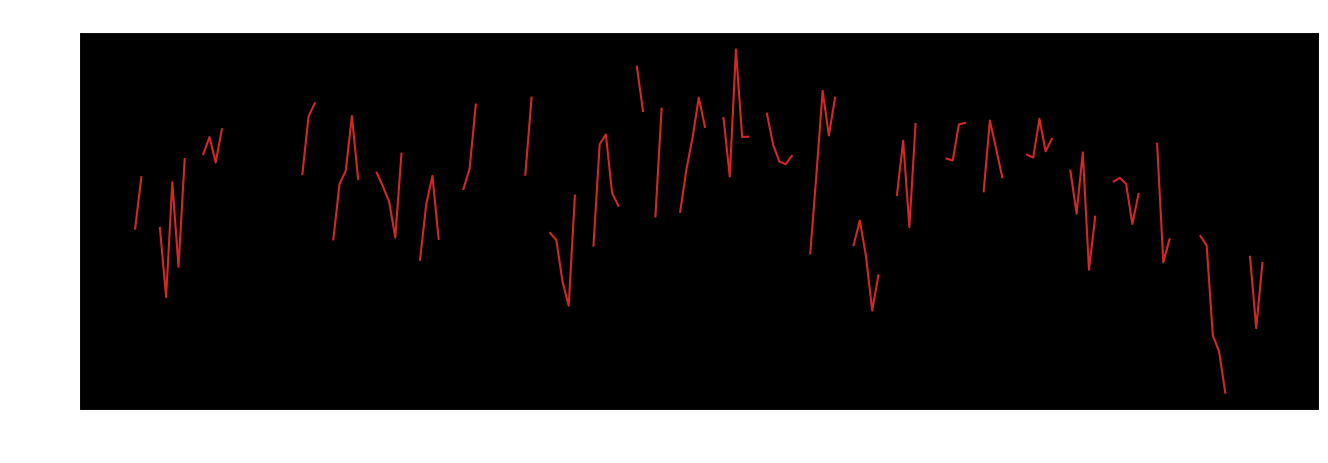

In [495]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_day.index, df_day['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

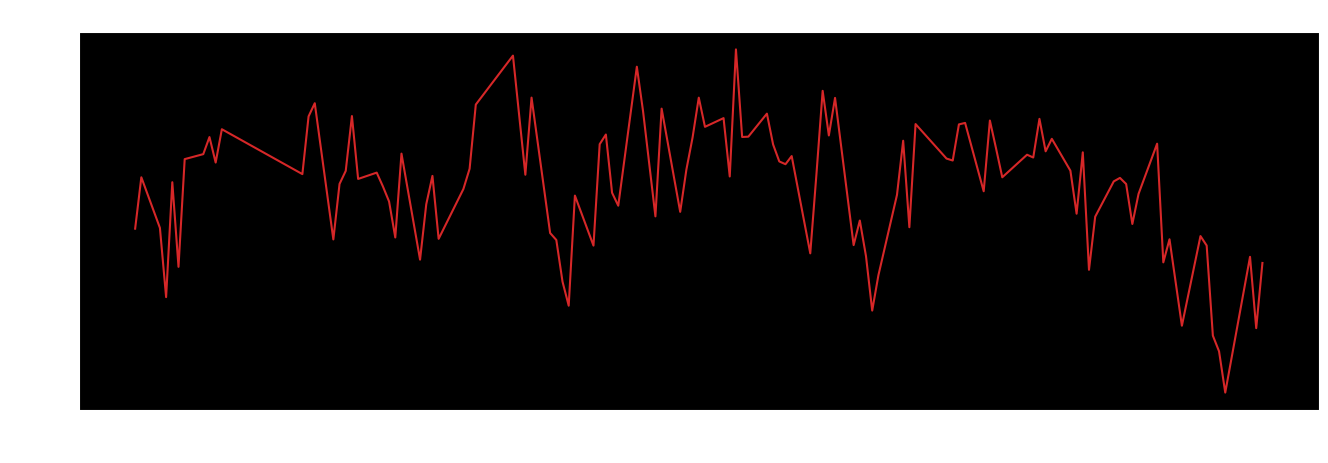

In [496]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_day_filtered.index, df_day_filtered['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

Text(0.5, 0.98, 'Decomposition')

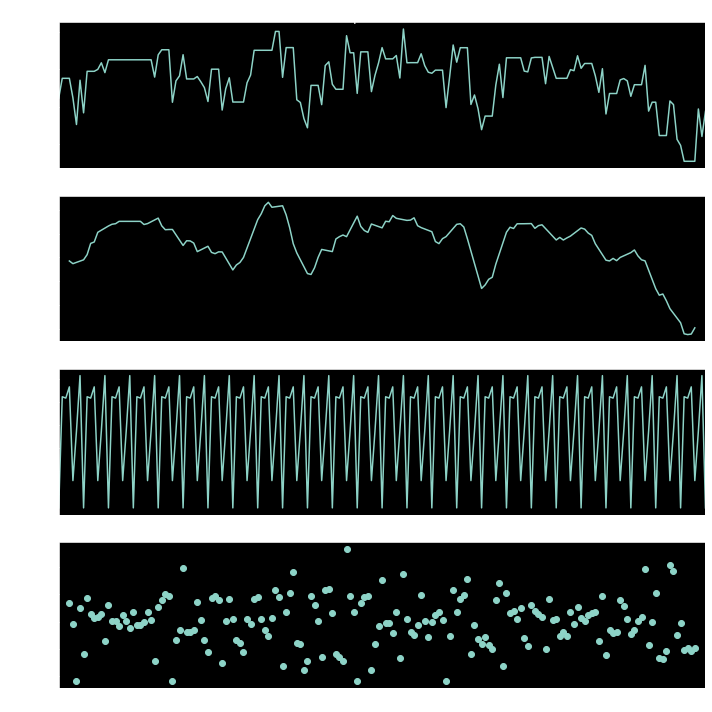

In [497]:
decomposition = seasonal_decompose(df_day_filled)
day_trend = decomposition.trend
day_seasonal = decomposition.seasonal
day_residual = decomposition.resid
decomposition.plot().suptitle("Decomposition")

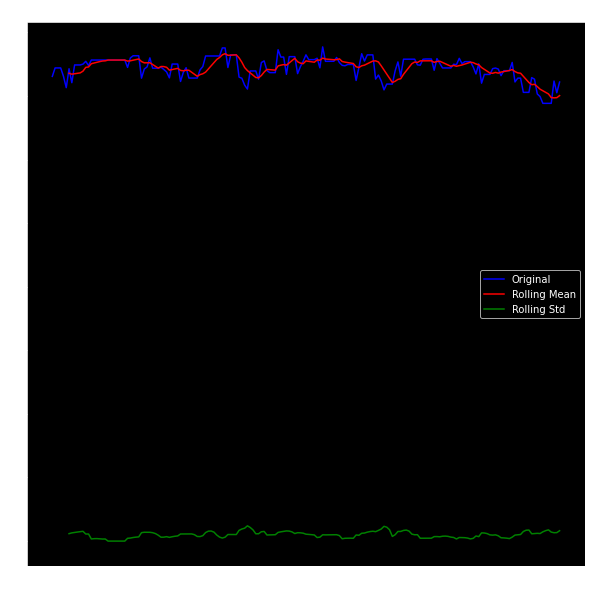

Results of Dickey-Fuller Test:
Test Statistic                  -3.736106
p-value                          0.003633
#Lags Used                       1.000000
Number of Observations Used    181.000000
Critical Value (1%)             -3.467005
Critical Value (5%)             -2.877644
Critical Value (10%)            -2.575355
dtype: float64


In [498]:
#Lets check for stationarity with our data series
rolmean_day= df_day_filled.rolling(7).mean()
rolstd_day = df_day_filled.rolling(7).std()
#Plot rolling statistics:
plt.plot(df_day_filled, color='blue',label='Original')
plt.plot(rolmean_day, color='red', label='Rolling Mean')
plt.plot(rolstd_day, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_day_filled, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

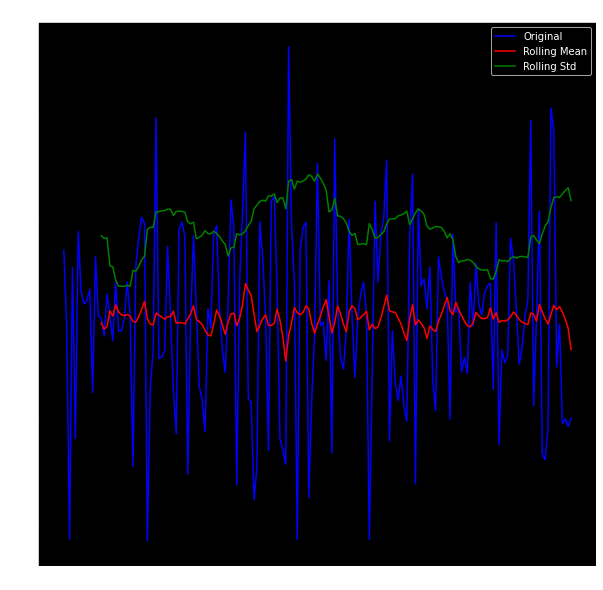

Results of Dickey-Fuller Test:
Test Statistic                -6.277101e+00
p-value                        3.876531e-08
#Lags Used                     1.300000e+01
Number of Observations Used    1.630000e+02
Critical Value (1%)           -3.471119e+00
Critical Value (5%)           -2.879441e+00
Critical Value (10%)          -2.576314e+00
dtype: float64


In [499]:
#Lets use the residual
day_residual.dropna(inplace=True)
rolmean= day_residual.rolling(14).mean()
rolstd = day_residual.rolling(14).std()
#Plot rolling statistics:
plt.plot(day_residual, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(day_residual, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Lets do forecasting for original series and for the rolling mean

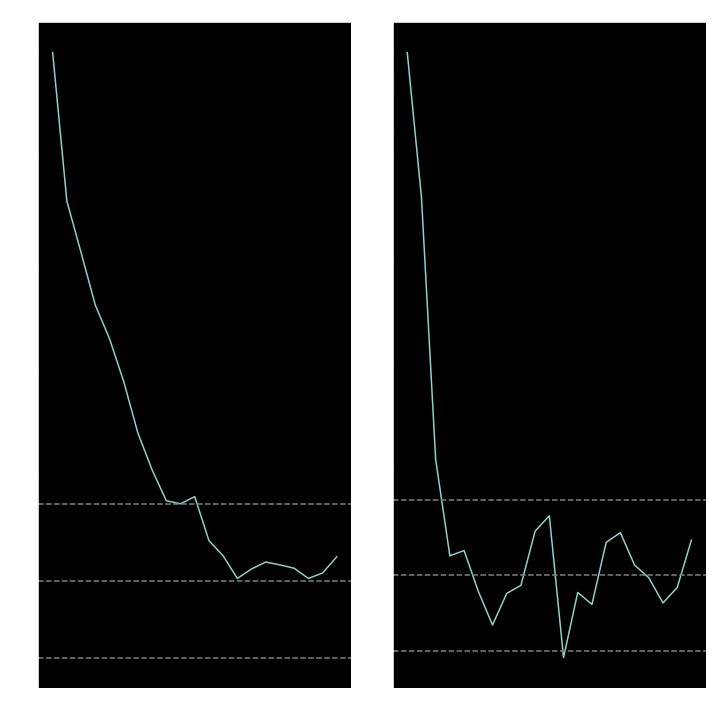

In [500]:
lag_acf = acf(df_day_filled, nlags=20)
lag_pacf = pacf(df_day_filled, nlags=20)

#Plot
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, ls='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_day_filled)), ls='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_day_filled)), ls='--', color='gray')
plt.title('Autocorrelation function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, ls='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_day_filled)), ls='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_day_filled)), ls='--', color='gray')
plt.title('Partial Autocorrelation function')
plt.tight_layout()

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS:0.02497706898442133')

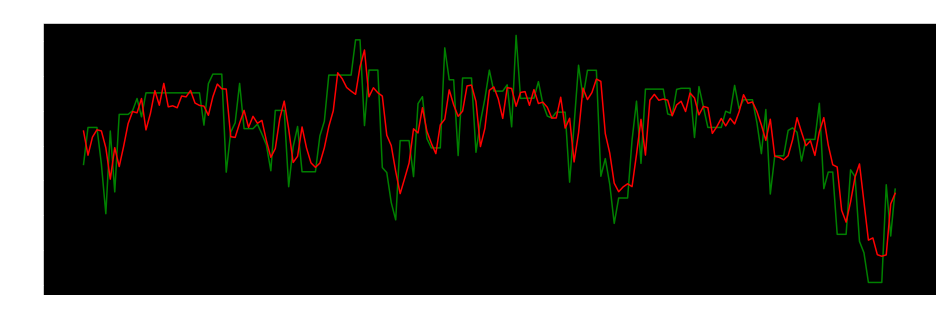

In [501]:
model= ARIMA(df_day_filled, order = (12,0,3))
ARIMA_model = model.fit()
plt.figure(figsize=(16,5))
plt.plot(df_day_filled, color = 'green')
plt.plot(ARIMA_model.fittedvalues,color= 'red')
plt.title(f"RSS:{sum(ARIMA_model.fittedvalues-df_day_filled)**2}")

Text(0.5, 1.0, 'Sarima,RSS:183.21670072261023')

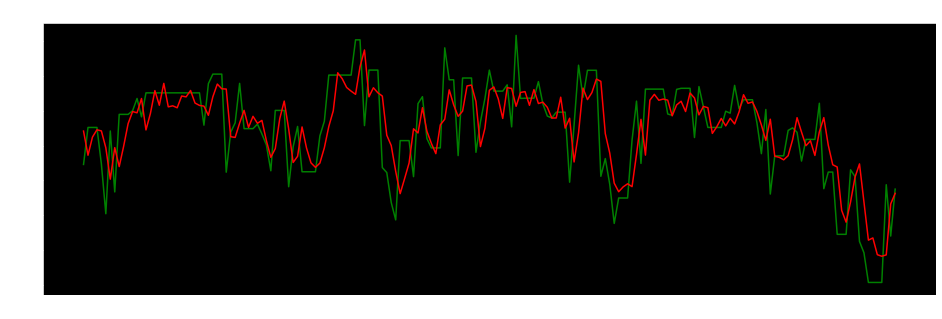

In [ ]:
model= SARIMAX(df_day_filled, order = (1,1,1),seasonal_order = (1,0,0,7))
SARIMA_model = model.fit()
plt.figure(figsize=(16,5))
plt.plot(df_day_filled, color = 'green')
plt.plot(ARIMA_model.fittedvalues,color= 'red')
plt.title(f"Sarima,RSS:{sum(SARIMA_model.fittedvalues-df_day_filled)**2}")

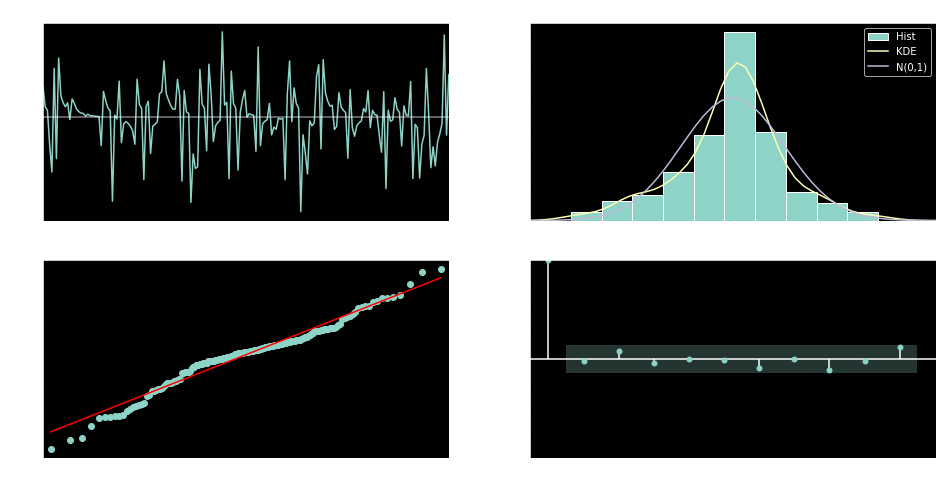

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(16,8))
plt.show()

Text(0.5, 1.0, 'Exponential Smoothing 5.753370378325833e-10')

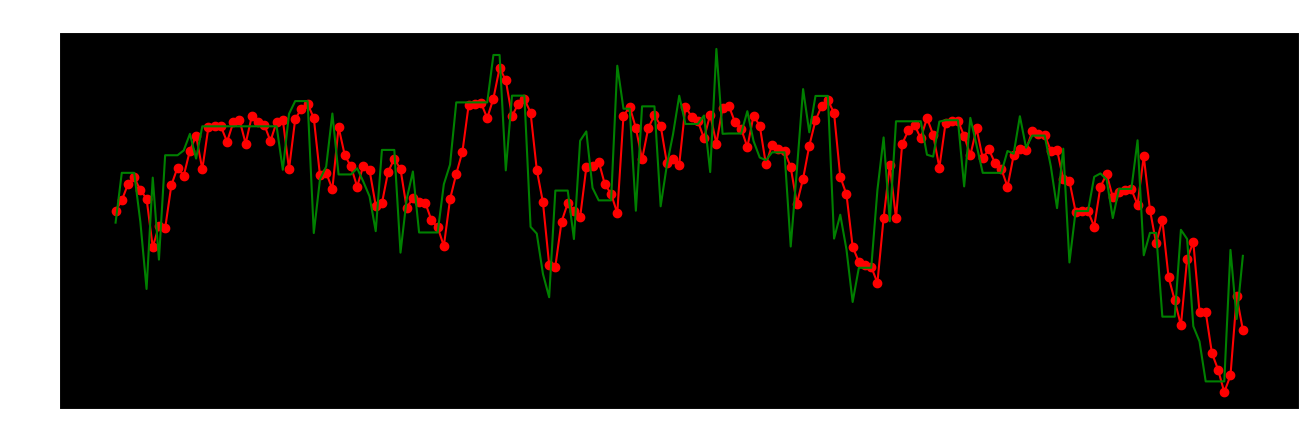

In [ ]:
#Try exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing
exp_smoothing_model = ExponentialSmoothing(df_day_filled, trend='add', seasonal='add').fit()
fcast1 = exp_smoothing_model.forecast(100).rename('Additive')
plt.figure(figsize=(16,5),dpi=100)
plt.plot(exp_smoothing_model.fittedvalues, marker='o', color='red')
plt.plot(df_day_filled, color ='green')
plt.title(f"Exponential Smoothing {sum(exp_smoothing_model.fittedvalues-df_day_filled)**2}")
# mse1 = ((fcast1 - y_to_test) ** 2).mean()
# print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
#         'period season_length={} and a Box-Cox transformation {}'.format(7,round(np.sqrt(mse1), 2)))

Text(0.5, 1.0, 'Holt Method 0.07010156531652424')

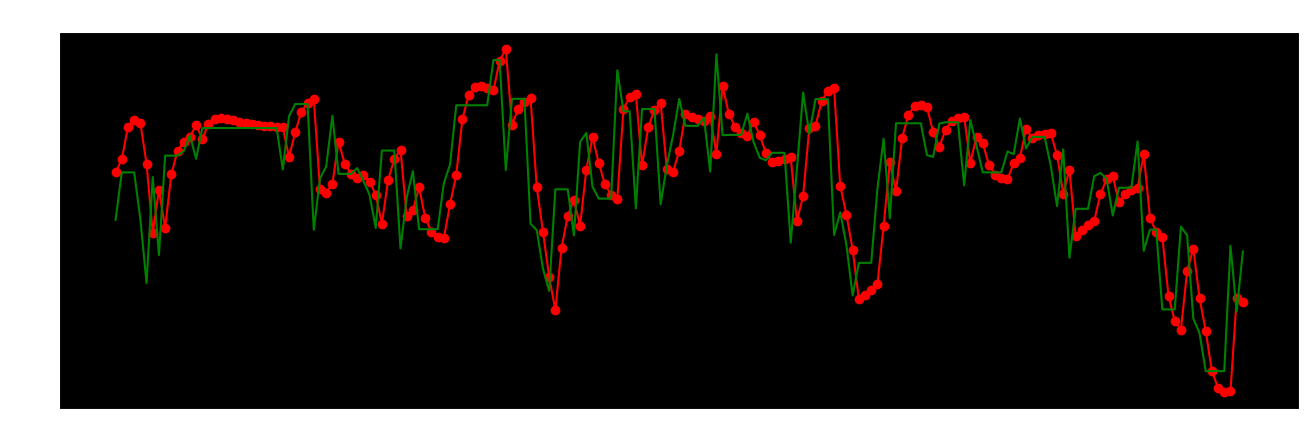

In [ ]:
#Try Holt
from statsmodels.tsa.api import Holt
smoothing_level=0.6
smoothing_slope= 0.2
holt_model = Holt(df_day_filled).fit(smoothing_level, smoothing_slope, optimized=False)
plt.figure(figsize=(16,5),dpi=100)
plt.plot(holt_model.fittedvalues, marker='o', color='red')
plt.plot(df_day_filled, color ='green')
plt.title(f"Holt Method {((holt_model.fittedvalues-df_day_filled)**2).mean()}")

In [ ]:
df_day_filled

Time
2021-12-09    14.614485
2021-12-10    14.880271
2021-12-11    14.880271
2021-12-12    14.880271
2021-12-13    14.618548
                ...    
2022-06-05    13.766797
2022-06-06    13.766797
2022-06-07    14.468827
2022-06-08    14.100000
2022-06-09    14.437168
Freq: D, Name: acceleration, Length: 183, dtype: float64

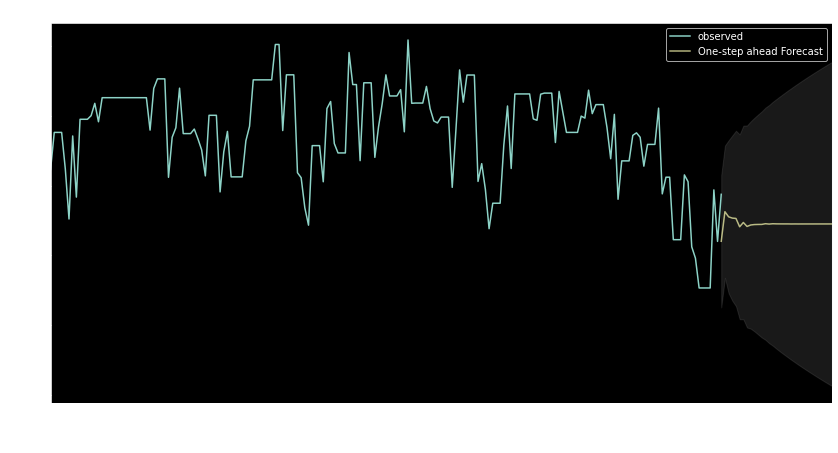

In [ ]:
pred = SARIMA_model.get_prediction(start=df_day_filled.index[-1], end = df_day_filled.index[-1]+DateOffset(months=1), dynamic=False)
pred_ci = pred.conf_int()
y_forecasted = pred.predicted_mean
# mse = ((y_forecasted - y_to_test) ** 2).mean()
# print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(7,round(np.sqrt(mse), 2)))
y=df_day_filled
ax = y.plot(label='observed')
y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
plt.legend()
plt.title("1 month forecast using SARIMAX")
plt.show()

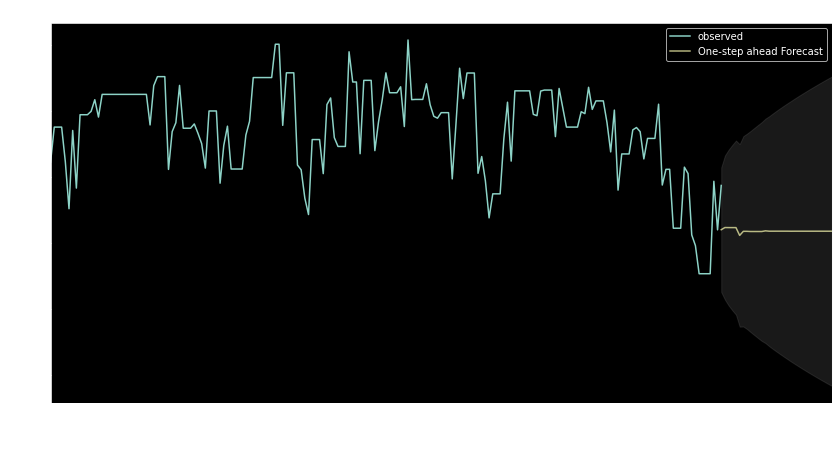

In [ ]:
pred = SARIMA_model.get_prediction(start=df_day_filled.index[-1], end = df_day_filled.index[-1]+DateOffset(months=1), dynamic=True, full_results=True)
pred_ci = pred.conf_int()
y_forecasted = pred.predicted_mean
# mse = ((y_forecasted - y_to_test) ** 2).mean()
# print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(7,round(np.sqrt(mse), 2)))
y=df_day_filled
ax = y.plot(label='observed')
y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
plt.legend()
plt.title("1 month forecast using SARIMAX dynamic")
plt.show()

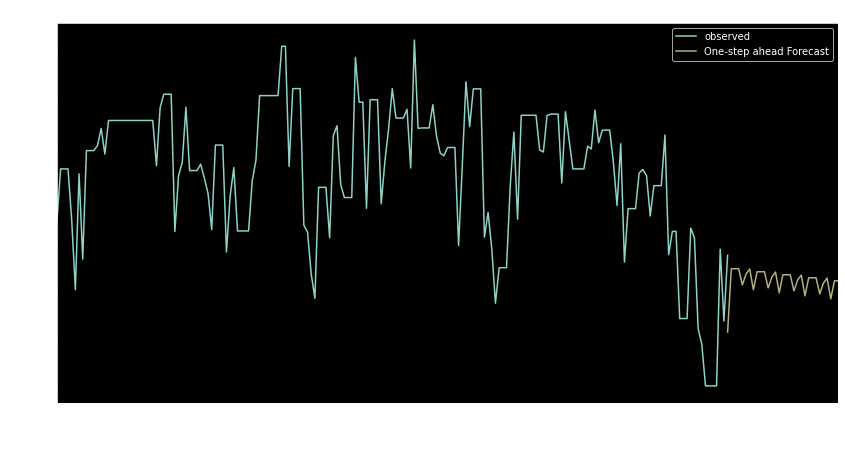

In [ ]:
pred = exp_smoothing_model.predict(start=df_day_filled.index[-1], end = df_day_filled.index[-1]+DateOffset(months=1))
# print(pred)
# pred_ci = pred.conf_int()
y_forecasted = pred
y=df_day_filled
ax = y.plot(label='observed')
y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='grey', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
plt.legend()
plt.title("1 month forecast using exponential smoothing")
plt.show()